# Desempenho CE-DDO-OFDM vs DDO-OFDM

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from optic.metrics     import fastBERcalc, signal_power
from optic.core        import parameters
from optic.dsp          import firFilter, lowPassFIR
from optic.models      import ssfm, photodiode, awgn

from tqdm.notebook     import tqdm
from utils.ofdm        import Tx, Rx, PAPR, calcSymbolRate
from commpy.utilities  import upsample
from tabulate          import tabulate

pi = np.pi

In [11]:
import scienceplots

plt.style.use('science')
font = {'size':20}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

## Parametrização do sistema

In [28]:
# Parâmetros do transmissor
paramTx = parameters()

# OFDM
paramTx.M    = 16                        # Número de símbolos da constelação QAM
paramTx.Nfft = 512                       # Tamanho da FFT
paramTx.Ns   = int(paramTx.Nfft/2) - 1   # Número de sub-portadoras
paramTx.N    = paramTx.Ns                # Número de portadoras de informação
paramTx.Nz = paramTx.Ns - paramTx.N      # Número de subportadoras nulas
paramTx.G    = 4                         # Tamanho do prefixo cíclico
paramTx.K    = 4                         # Número de portadoras piloto por bloco OFDM

Rb           = 3e9                       # Taxa de bits/s
paramTx.Rs   = calcSymbolRate(paramTx.M, Rb, paramTx.Nfft, paramTx.K, paramTx.G, True)
paramTx.SpS  = 16                        # Amostras por símbolo
paramTx.Fa   = paramTx.Rs*paramTx.SpS    # Frequência de amostragem
paramTx.Fc   = 193.4e12                  # Frequência da portadora óptica
# Portadora elétrica
paramTx.fc = 1e9                         # Frequência da portadora [Hz]
paramTx.A  = 1.15                         # Amplitude da portadora - CE-OFDM
paramTx.g  = 0.45                         # Ganho pré-MZM do DDO-OFDM
# MZM e potência de entrada
paramTx.Vπ = 4
paramTx.Vb = -0.5*paramTx.Vπ
paramTx.Pi_dBm = 2

Int = int(paramTx.N/paramTx.K)
carriers = np.arange(0, paramTx.N)
pilot_carriers = np.append(carriers[0::Int], carriers[-1])

In [29]:
filtro_optico_Tx = lowPassFIR(4e9, paramTx.Fa, 8001, typeF='rect')
filtro_optico_DD = lowPassFIR(1.9e9, paramTx.Fa, 8001, typeF='rect')
filtro_optico_CEDD = lowPassFIR(2.9e9, paramTx.Fa, 8001, typeF='rect')

In [44]:
# Parâmetros da fibra
paramCh = parameters()

paramCh.Ltotal  = 1000        # Comprimento total do link [km]
paramCh.Lspan   = 100         # Comprimento de um span de fibra [km]
paramCh.hz      = 1.0         # Comprimento do passo para o método SSF [km]
paramCh.alpha   = 0.2         # Atenuação da fibra [dB/km]
paramCh.D       = 16          # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma   = 1.3         # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.amp     = 'edfa'      # Tipo de amplificador
paramCh.NF      = 5         # Figura de ruído do amplificador [dB]
paramCh.Fc      = paramTx.Fc  # Frequência da portadora óptica [Hz]
paramCh.prgsBar = False

In [31]:
# Parâmetros do fotodetector
paramPD = parameters()

paramPD.R  = 1           # Responsividade
paramPD.Tc = 25          # Temperatura [°C]
paramPD.Id = 5e-9        # Corrente de escuro [A]
paramPD.RL = 50          # Resistência [Ω]
paramPD.B  = 2.5e9       # Largura de banda [Hz]
paramPD.Fs = paramTx.Fa  # Frequência de amostragem
paramPD.N  = 8001        # Tamanho do resposta do filtro
paramPD.ideal = True    # Definição do modelo: ideal ou real

In [32]:
# Parâmetros do receptor
paramRx = parameters()

paramRx.SpS = paramTx.SpS       # Amostras por símbolo
paramRx.Fa  = paramTx.Fa        # Frequência de amostragem
paramRx.fc  = paramTx.fc        # Frequência da portadora elétrica
paramRx.Nfft = paramTx.Nfft
paramRx.Ns = paramTx.Ns
paramRx.N  = paramTx.N
paramRx.Nz = paramTx.Nz
paramRx.G  = paramTx.G
paramRx.K  = paramTx.K

In [33]:
# Parametrização do sistema

table = [['Grandeza', 'Parâmetro', 'Valor'],
         ['Taxa de transmissão', 'Rb', f'{round(Rb*1e-9, 2)} Gb/s'], 
         ['Tamanho da FFT', 'Nfft', f'{paramTx.Nfft}'], 
         ['Tamanho da constelação', 'M', f'{paramTx.M}'], 
         ['Tamanho do prefixo cíclico', 'G', f'{paramTx.G}'], 
         ['Total de subportadoras', 'Ns', f'{paramTx.Ns}'], 
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Subportadoras anuladas', 'Nz', f'{paramTx.Nz}'],
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Largura de banda', 'Bw', f'{round(paramTx.Rs*1e-9, 2)} GHz'], 
         ['Espaçamento entre subportadoras', 'Delta_f', f'{ round((paramTx.Rs/paramTx.Nfft)*1e-6, 2)} MHz'],
         ['Duração do símbolo OFDM', 'Ts', f'{round((paramTx.Nfft/paramTx.Rs)*1e6,2)} us'],
         ['Duração do prefixo cíclico', 'Tg', f'{round((paramTx.G/paramTx.Rs)*1e9,2)} ns'],
         ['Frequência central', 'fc', f'{round((paramTx.fc)*1e-9,2)} GHz']]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════════════════════╤═════════════╤══════════╕
│ Grandeza                        │ Parâmetro   │ Valor    │
╞═════════════════════════════════╪═════════════╪══════════╡
│ Taxa de transmissão             │ Rb          │ 3.0 Gb/s │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da FFT                  │ Nfft        │ 512      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da constelação          │ M           │ 16       │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho do prefixo cíclico      │ G           │ 4        │
├─────────────────────────────────┼─────────────┼──────────┤
│ Total de subportadoras          │ Ns          │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras de informação     │ N           │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras anuladas          │ Nz          │ 0        │
├───────────────────────

In [34]:
# Sinal DDO-OFDM
paramTx.g = 0.45
paramTx.Scheme = "DDO-OFDM"

sigTxoDD, sigTxDD, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)
sigTxoDD = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxoDD/np.sqrt(signal_power(sigTxoDD))

In [35]:
# Sinal CE-DDO-OFDM
paramTx.A = 1.15
paramTx.H = 0.45/(2*pi)
paramTx.Scheme = "CE-DDO-OFDM"

sigTxoCE, sigTxCE, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
sigTxoCE = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxoCE/np.sqrt(signal_power(sigTxoCE))

Text(0.5, 1.0, 'SigTxo')

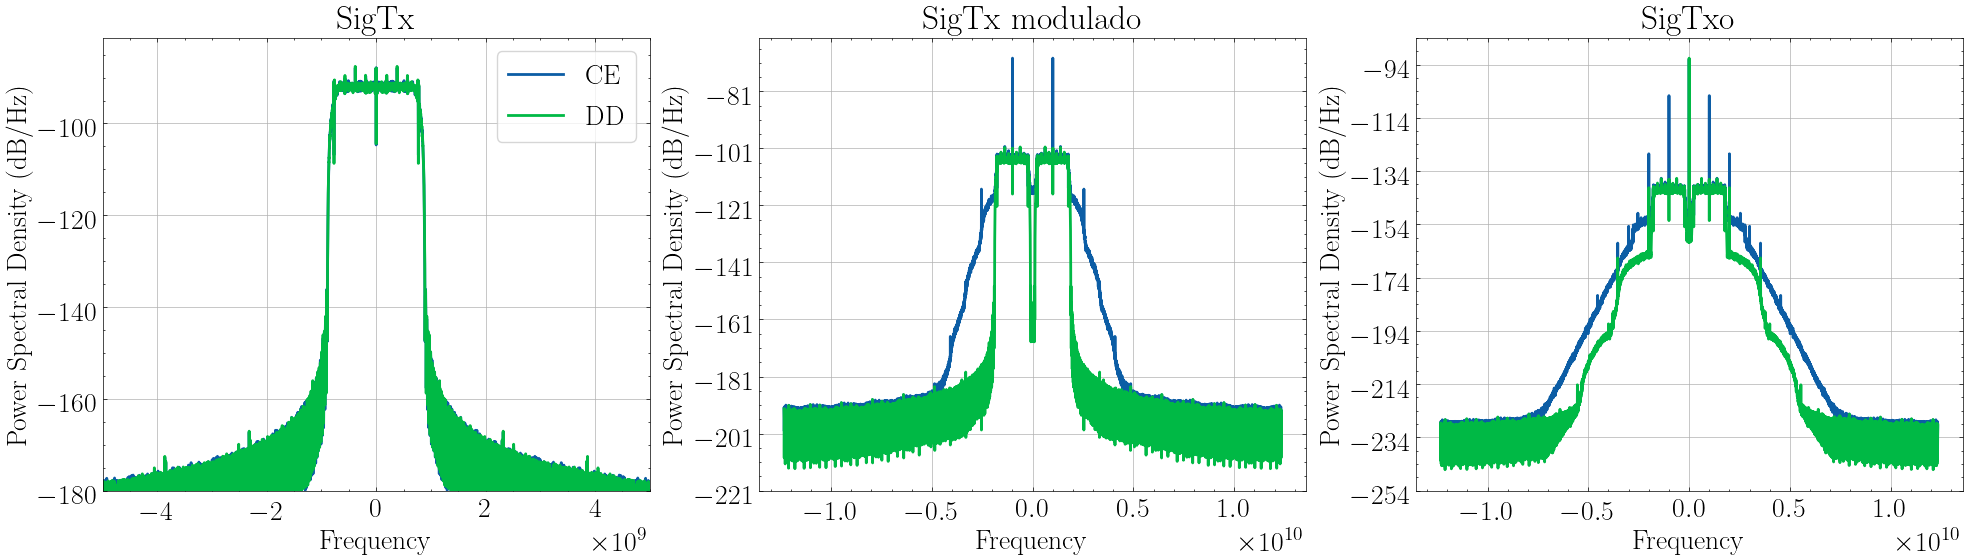

In [36]:
fig, ax = plt.subplots(1, 3, figsize = (24, 6))

ax[0].psd(sigTxCE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[0].psd(sigTxDD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[0].set_title('SigTx')
ax[0].legend(frameon = True)
ax[0].set_xlim(-5e9, 5e9)
ax[0].set_ylim(-180)

ax[1].psd(sigTx_CE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[1].psd(sigTx_DD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[1].set_title('SigTx modulado')
#ax[1].set_xlim(-5e9, 5e9)
#ax[1].set_ylim(-200)

ax[2].psd(sigTxoCE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[2].psd(sigTxoDD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[2].set_title('SigTxo')
#ax[2].set_xlim(-5e9, 5e9)
#ax[2].set_ylim(-200)

In [58]:
A

array([0.84852814, 1.13137085, 1.41421356, 1.69705627, 1.97989899,
       2.2627417 , 2.54558441, 2.82842712])

# 1 - Avaliação do $h$ e da OMI

In [59]:
OMI = np.arange(0.05, 0.61, 0.05)
A  = paramTx.Vπ*OMI*np.sqrt(2)
h  = np.array([0.25, 0.35, 0.45, 0.55])/(2*pi)
paramTx.Vb = -0.5*paramTx.Vπ

BER_CEDD_OMI = np.zeros((len(h), len(A)))
SNR_CEDD_OMI = np.zeros((len(h), len(A)))

osnrTx = 30

In [60]:
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(h))):
    paramTx.H = h[i]
    paramRx.H = paramTx.H
    
    for ind, AA in enumerate(A):   
        paramTx.A = AA
        
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
        sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
        
        # optical filter
        sigTxo = firFilter(filtro_optico_Tx, sigTxo)
        
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
        
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        aux = 0
        for r in range(int(len(symbTx)/paramTx.N)):
            symbTx[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbTx = symbTx[~np.isnan(symbTx)]

        aux = 0
        for r in range(int(len(symbRx)/paramTx.N)):
            symbRx[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbRx = symbRx[~np.isnan(symbRx)]

        aux = 0
        for r in range(int(len(symbRx_neq)/paramTx.N)):
            symbRx_neq[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbRx_neq = symbRx_neq[~np.isnan(symbRx_neq)]    
        
        BER_CEDD_OMI[i, ind], _, SNR_CEDD_OMI[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')  

  0%|          | 0/4 [00:00<?, ?it/s]

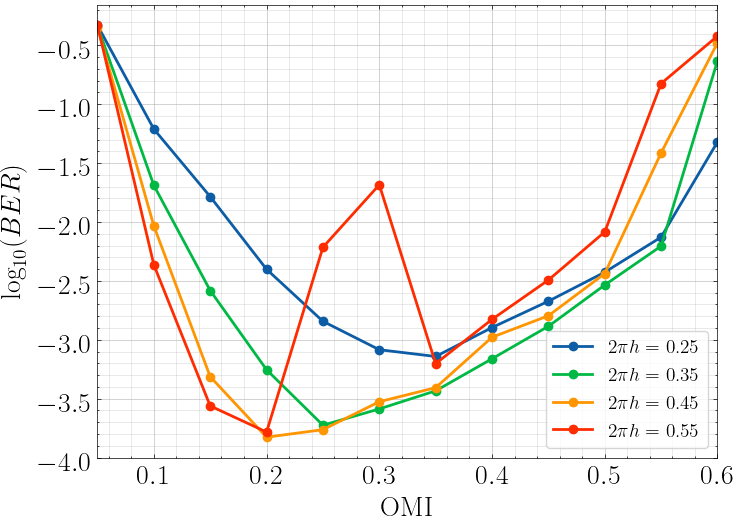

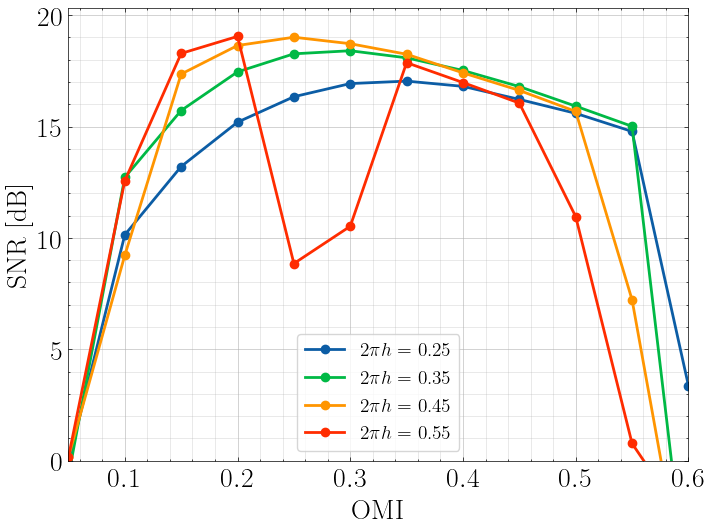

In [70]:
plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(OMI, np.log10(BER_CEDD_OMI[i,:]), '-o', ms = 6, lw = 2, label = f'$2\pi h = $ {round(2*pi*h[i], 2)}')

#plt.title("BER vs OMI B2B")
plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-4)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(OMI, SNR_CEDD_OMI[i,:], '-o', ms = 6, lw = 2, label = f'$2\pi h = $ {round(2*pi*h[i], 2)}')

plt.xlabel(r"OMI")
plt.ylabel(r"SNR [dB]")
plt.ylim(0)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

In [61]:
OMI = np.arange(0.05, 0.61, 0.05)
A  = paramTx.Vπ*OMI*np.sqrt(2)
Vb  = np.array([-0.4, -0.5, -0.6])*paramTx.Vπ

paramTx.Pi_dBm = 2
paramTx.H = 0.45/(2*pi)
paramRx.H = paramTx.H

BER_CEDD_Vb = np.zeros((len(Vb), len(A)))
SNR_CEDD_Vb = np.zeros((len(Vb), len(A)))

paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(Vb))):
    paramTx.Vb = Vb[i]
    
    for ind, AA in enumerate(A):
        paramTx.A = AA
        
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
              
        snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
        sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
        
        # optical filter
        sigTxo = firFilter(filtro_optico_Tx, sigTxo)
        
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
        ipd = photodiode(sigRxo, paramPD)
        
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        aux = 0
        for r in range(int(len(symbTx)/paramTx.N)):
            symbTx[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbTx = symbTx[~np.isnan(symbTx)]

        aux = 0
        for r in range(int(len(symbRx)/paramTx.N)):
            symbRx[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbRx = symbRx[~np.isnan(symbRx)]

        aux = 0
        for r in range(int(len(symbRx_neq)/paramTx.N)):
            symbRx_neq[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbRx_neq = symbRx_neq[~np.isnan(symbRx_neq)]    
        
        BER_CEDD_Vb[i, ind], _, SNR_CEDD_Vb[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')      

  0%|          | 0/3 [00:00<?, ?it/s]

In [83]:
SNR_CEDD_Vb[2,5] = 18

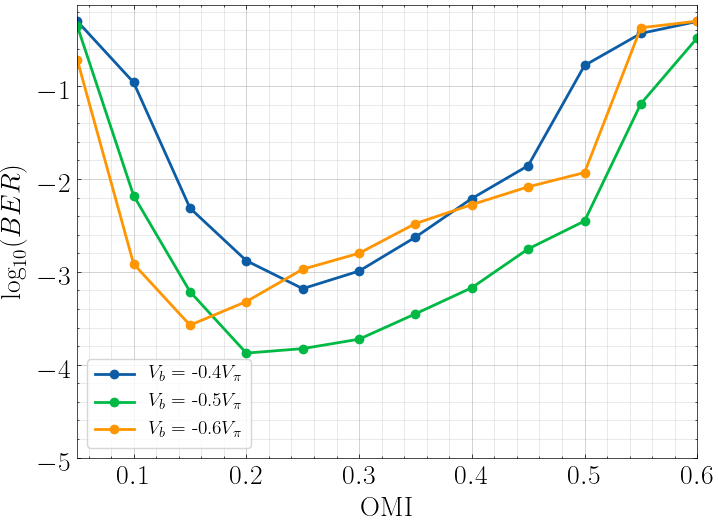

<Figure size 900x400 with 0 Axes>

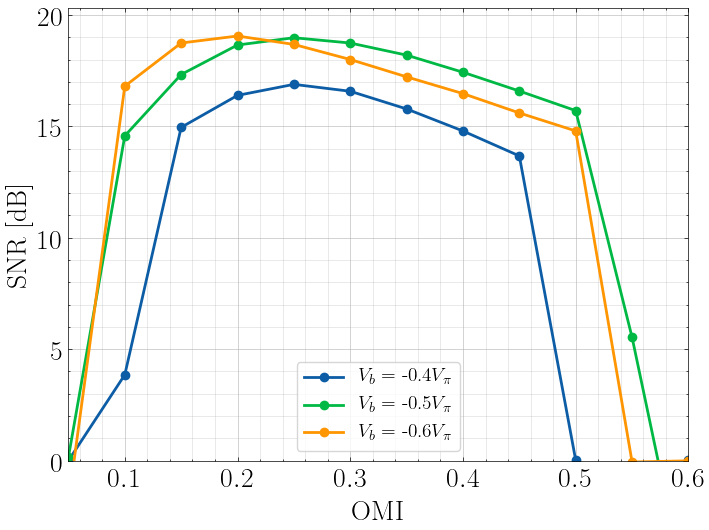

In [84]:
# BER vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, np.log10(BER_CEDD_Vb[i,:]), '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

#plt.title("BER vs OMI B2B")
plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)
plt.figure(figsize = (9, 4))

# SNR vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, SNR_CEDD_Vb[i,:], '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"SNR [dB]")
plt.ylim(0)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

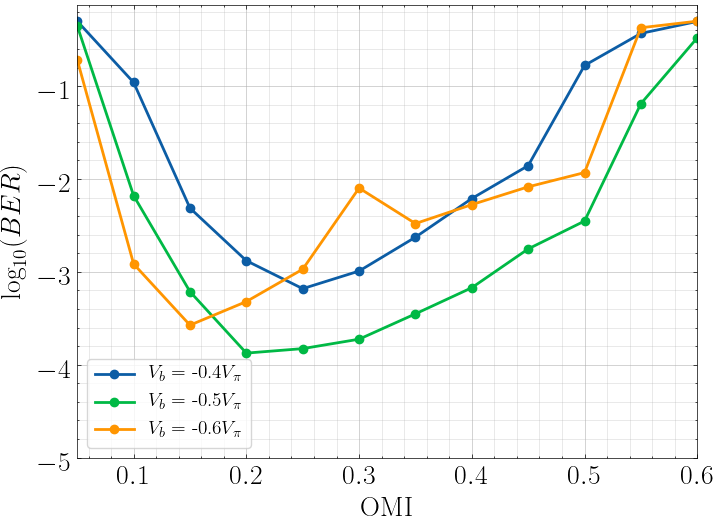

<Figure size 900x400 with 0 Axes>

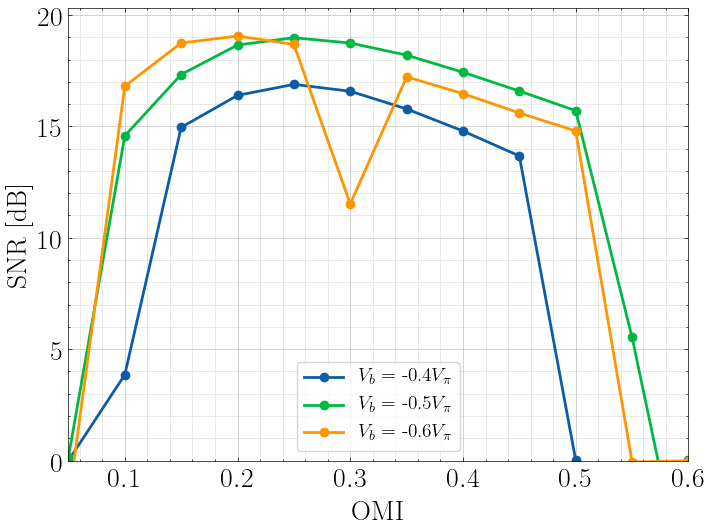

In [62]:
# BER vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, np.log10(BER_CEDD_Vb[i,:]), '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

#plt.title("BER vs OMI B2B")
plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)
plt.figure(figsize = (9, 4))

# SNR vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, SNR_CEDD_Vb[i,:], '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"SNR [dB]")
plt.ylim(0)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

In [63]:
g = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
Vb  = np.array([-0.4, -0.5, -0.6])*paramTx.Vπ

OMI = np.zeros(len(g))

BER_DD_Vb = np.zeros((len(Vb), len(g)))
SNR_DD_Vb = np.zeros((len(Vb), len(g)))

paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(Vb))):
    paramTx.Vb = Vb[i]
    
    for ind, gg in enumerate(g):
        paramTx.g = gg
        
        sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
        
        if(i == 0):
            OMI[ind] = np.sqrt(np.mean((sigTx_DD)**2))/paramTx.Vπ
    
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
        sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
        
        # optical filter
        sigTxo = firFilter(filtro_optico_Tx, sigTxo)
        
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        sigRxo = firFilter(filtro_optico_DD, sigRxo)
        
        ipd = photodiode(sigRxo, paramPD)
        
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

        aux = 0
        for r in range(int(len(symbTx)/paramTx.N)):
            symbTx[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbTx = symbTx[~np.isnan(symbTx)]

        aux = 0
        for r in range(int(len(symbRx)/paramTx.N)):
            symbRx[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbRx = symbRx[~np.isnan(symbRx)]

        aux = 0
        for r in range(int(len(symbRx_neq)/paramTx.N)):
            symbRx_neq[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbRx_neq = symbRx_neq[~np.isnan(symbRx_neq)]   
        
        BER_DD_Vb[i, ind], _, SNR_DD_Vb[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')   

  0%|          | 0/3 [00:00<?, ?it/s]

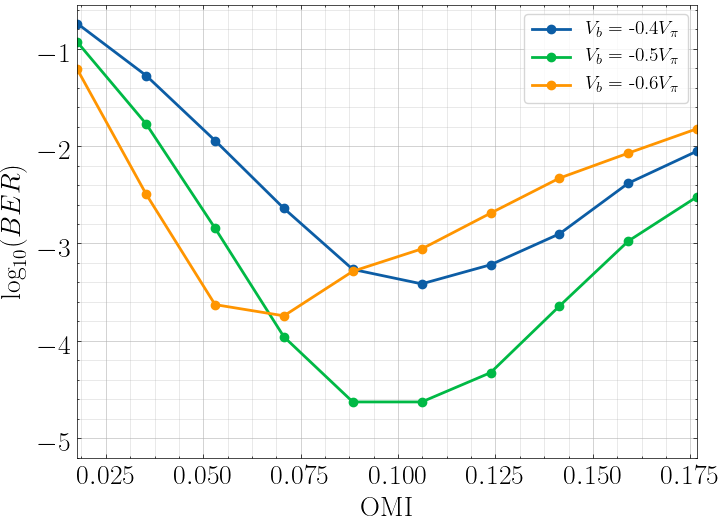

<Figure size 900x400 with 0 Axes>

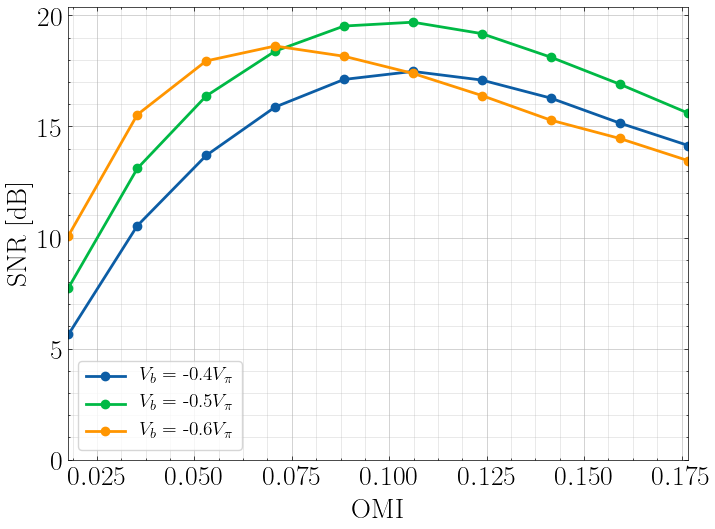

In [66]:
# BER vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, np.log10(BER_DD_Vb[i,:]), '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

#plt.title("BER vs OMI B2B")
plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5.2)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)
plt.figure(figsize = (9, 4))

# SNR vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, SNR_DD_Vb[i,:], '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"SNR [dB]")
plt.ylim(0)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# 1 - Avaliação do $h$ e do $V_b$

In [50]:
h = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])/(2*pi)
Vb  = np.array([-0.4, -0.5, -0.6])*paramTx.Vπ

BER_CEDD_16QAM = np.zeros((len(Vb), len(h)))
SNR_CEDD_16QAM = np.zeros((len(Vb), len(h)))

paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(Vb))):
    paramTx.Vb = Vb[i]
    
    for ind, hh in enumerate(h):
        paramTx.H = hh
        paramRx.H = paramTx.H
        
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        ipd = photodiode(sigRxo, paramPD)
        
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_CEDD_16QAM[i, ind], _, SNR_CEDD_16QAM[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')  

0.5

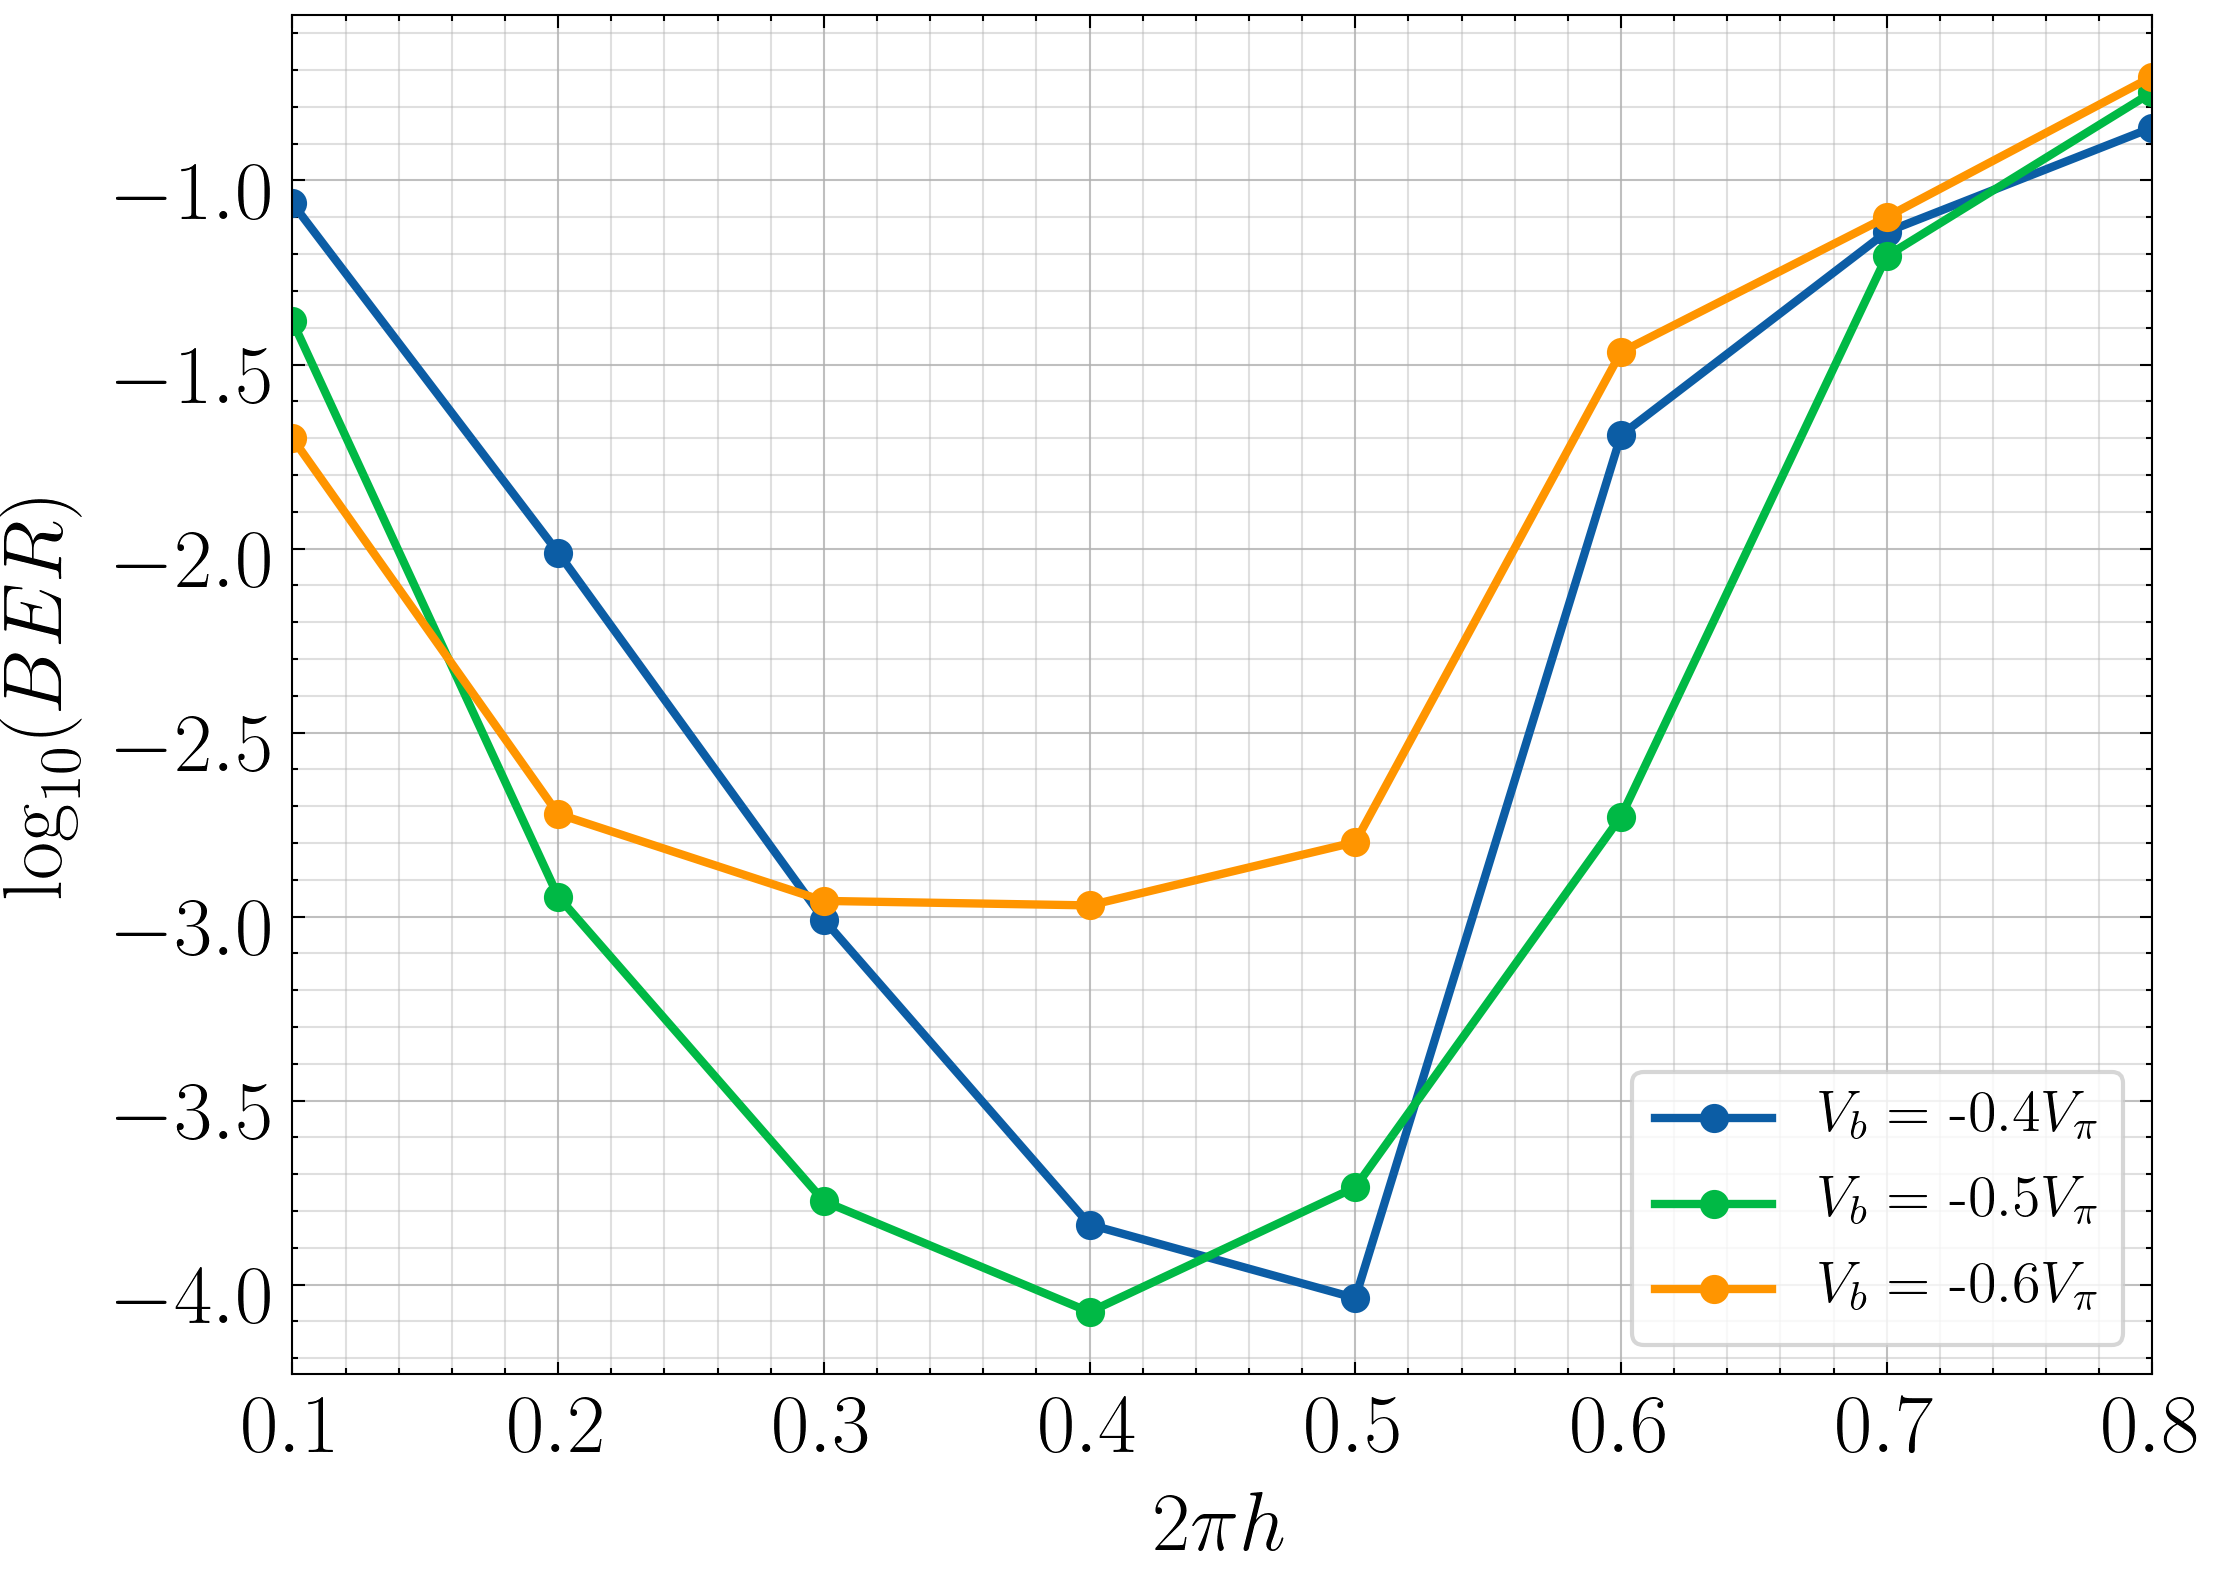

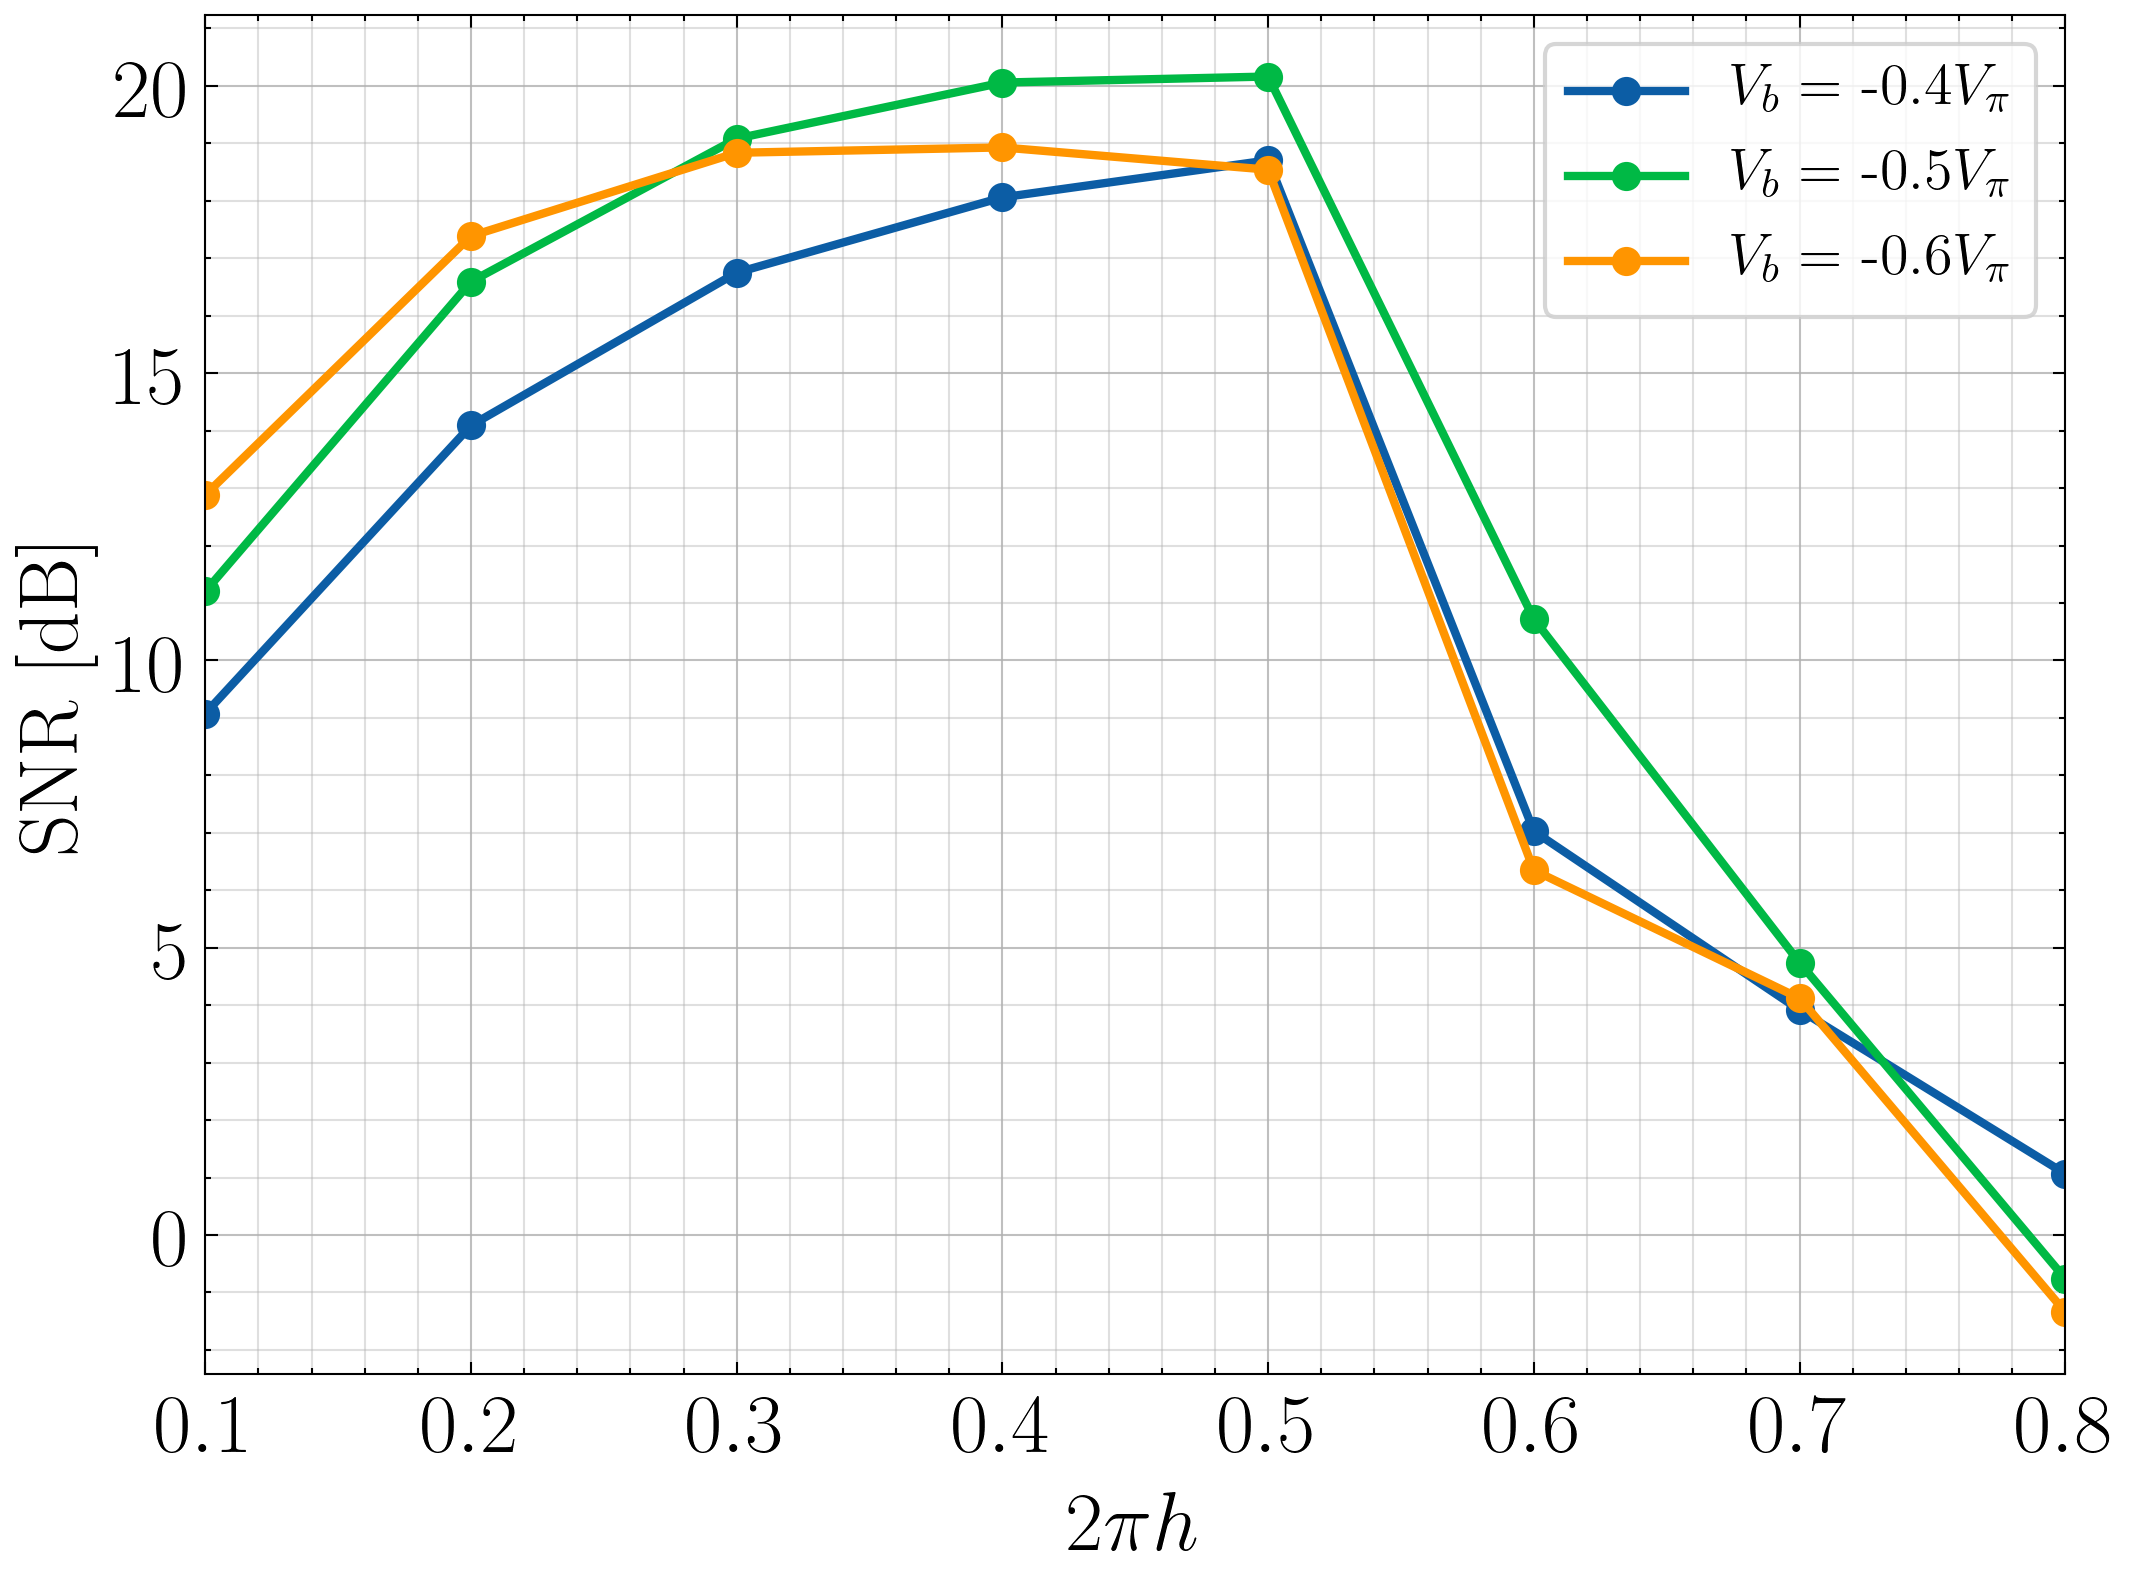

In [20]:
# BER vs 2πh - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(2*pi*h, np.log10(BER_CEDD_16QAM[i,:]), '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

#plt.title("BER vs OMI B2B")
plt.xlabel(r"$2\pi h$")
plt.ylabel(r"$\log_{10}(BER)$")
#plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(2*pi*h), max(2*pi*h))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# SNR vs 2πh - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(2*pi*h, SNR_CEDD_16QAM[i,:], '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"$2\pi h$")
plt.ylabel(r"SNR [dB]")
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(2*pi*h), max(2*pi*h))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# 2 - BER, SNR vs Pi - CE e DDO

## 2.1 - Sem compensação de dispersão

In [71]:
paramTx.H = 0.45/(2*pi)
paramRx.H = paramTx.H
paramTx.Vb = -0.5*paramTx.Vπ
paramTx.A  = 1.15
paramCh.Ltotal = 1000

Pi = np.arange(-5, 12.5)

BER_CEDD_Pi = np.zeros(len(Pi))
SNR_CEDD_Pi = np.zeros(len(Pi))

paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(Pi))):
    paramTx.Pi_dBm = Pi[i]
        
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
        
    # optical filter
    sigTxo = firFilter(filtro_optico_Tx, sigTxo)
    
    sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
    sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
    
    ipd = photodiode(sigRxo, paramPD)
    
    symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
    
    aux = 0
    for r in range(int(len(symbTx)/paramTx.N)):
        symbTx[aux:aux+paramTx.N][pilot_carriers] = np.nan
        aux += paramTx.N
    symbTx = symbTx[~np.isnan(symbTx)]

    aux = 0
    for r in range(int(len(symbRx)/paramTx.N)):
        symbRx[aux:aux+paramTx.N][pilot_carriers] = np.nan
        aux += paramTx.N
    symbRx = symbRx[~np.isnan(symbRx)]

    aux = 0
    for r in range(int(len(symbRx_neq)/paramTx.N)):
        symbRx_neq[aux:aux+paramTx.N][pilot_carriers] = np.nan
        aux += paramTx.N
    symbRx_neq = symbRx_neq[~np.isnan(symbRx_neq)] 
    
    BER_CEDD_Pi[i], _, SNR_CEDD_Pi[i] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')    

  0%|          | 0/18 [00:00<?, ?it/s]

In [72]:
paramTx.Vb = -0.5*paramTx.Vπ

BER_DD_Pi = np.zeros(len(Pi))
SNR_DD_Pi = np.zeros(len(Pi))

paramTx.g = 0.45

paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(Pi))):
    paramTx.Pi_dBm = Pi[i]
        
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
    
    # optical filter
    sigTxo = firFilter(filtro_optico_Tx, sigTxo)
    
    sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
    sigRxo = firFilter(filtro_optico_DD, sigRxo)
    
    ipd = photodiode(sigRxo, paramPD)
        
    symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
    aux = 0
    for r in range(int(len(symbTx)/paramTx.N)):
        symbTx[aux:aux+paramTx.N][pilot_carriers] = np.nan
        aux += paramTx.N
    symbTx = symbTx[~np.isnan(symbTx)]

    aux = 0
    for r in range(int(len(symbRx)/paramTx.N)):
        symbRx[aux:aux+paramTx.N][pilot_carriers] = np.nan
        aux += paramTx.N
    symbRx = symbRx[~np.isnan(symbRx)]

    aux = 0
    for r in range(int(len(symbRx_neq)/paramTx.N)):
        symbRx_neq[aux:aux+paramTx.N][pilot_carriers] = np.nan
        aux += paramTx.N
    symbRx_neq = symbRx_neq[~np.isnan(symbRx_neq)]         
    
    BER_DD_Pi[i], _, SNR_DD_Pi[i] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')   

  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


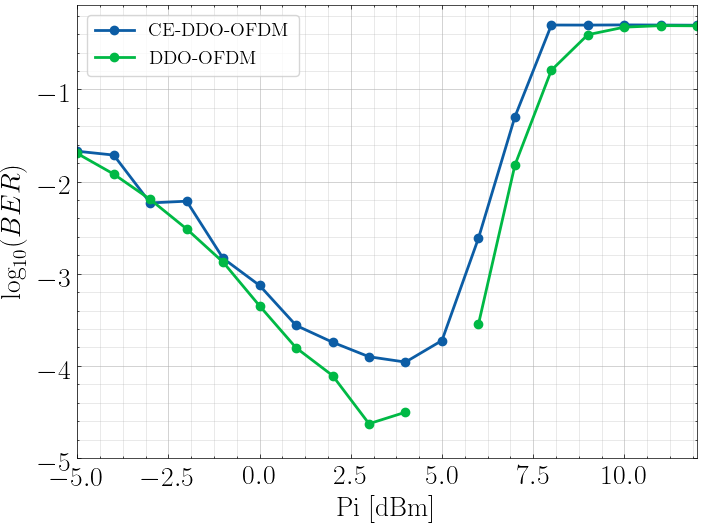

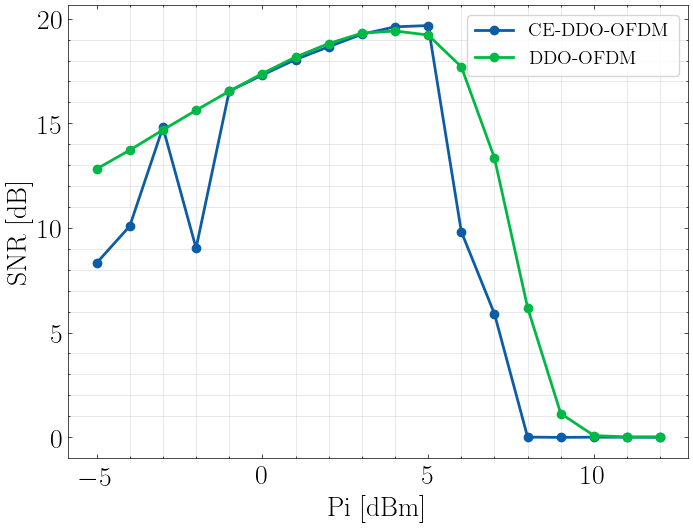

In [75]:
# BER vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, np.log10(BER_CEDD_Pi), '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Pi, np.log10(BER_DD_Pi), '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# SNR vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, SNR_CEDD_Pi, '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Pi, SNR_DD_Pi, '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"SNR [dB]")
plt.legend(fontsize = 14, frameon = True)
#plt.xlim(min(Pi),6)
#plt.ylim(8)
plt.grid(which='minor', alpha=0.4)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


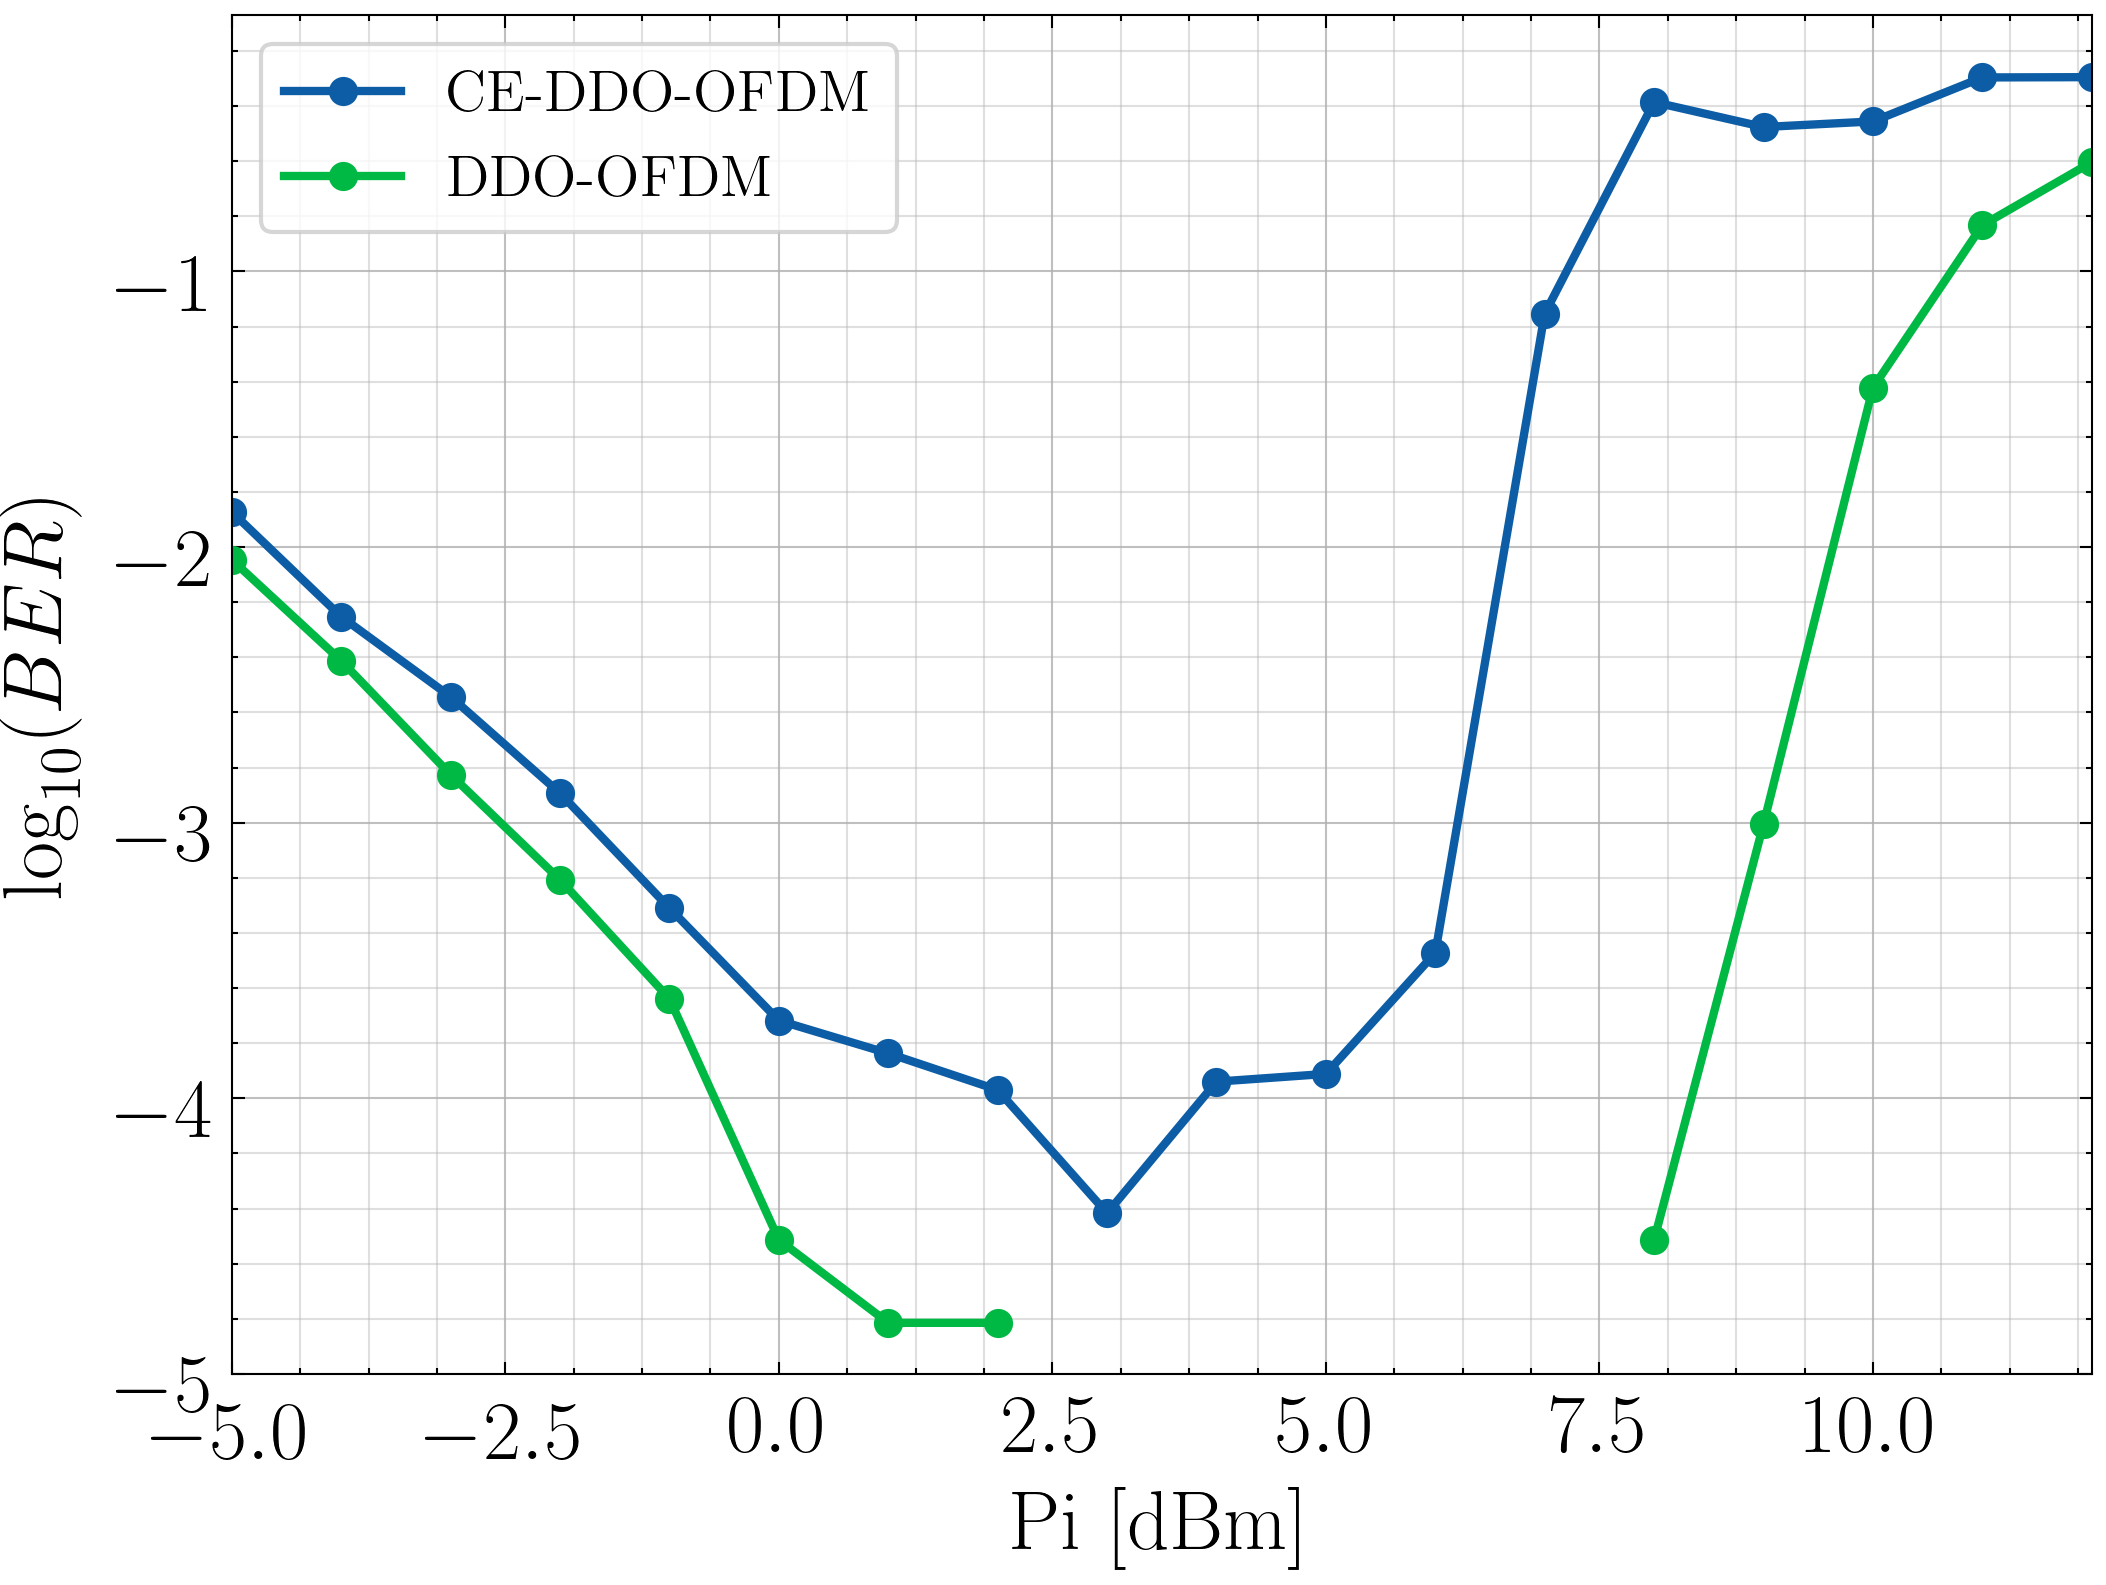

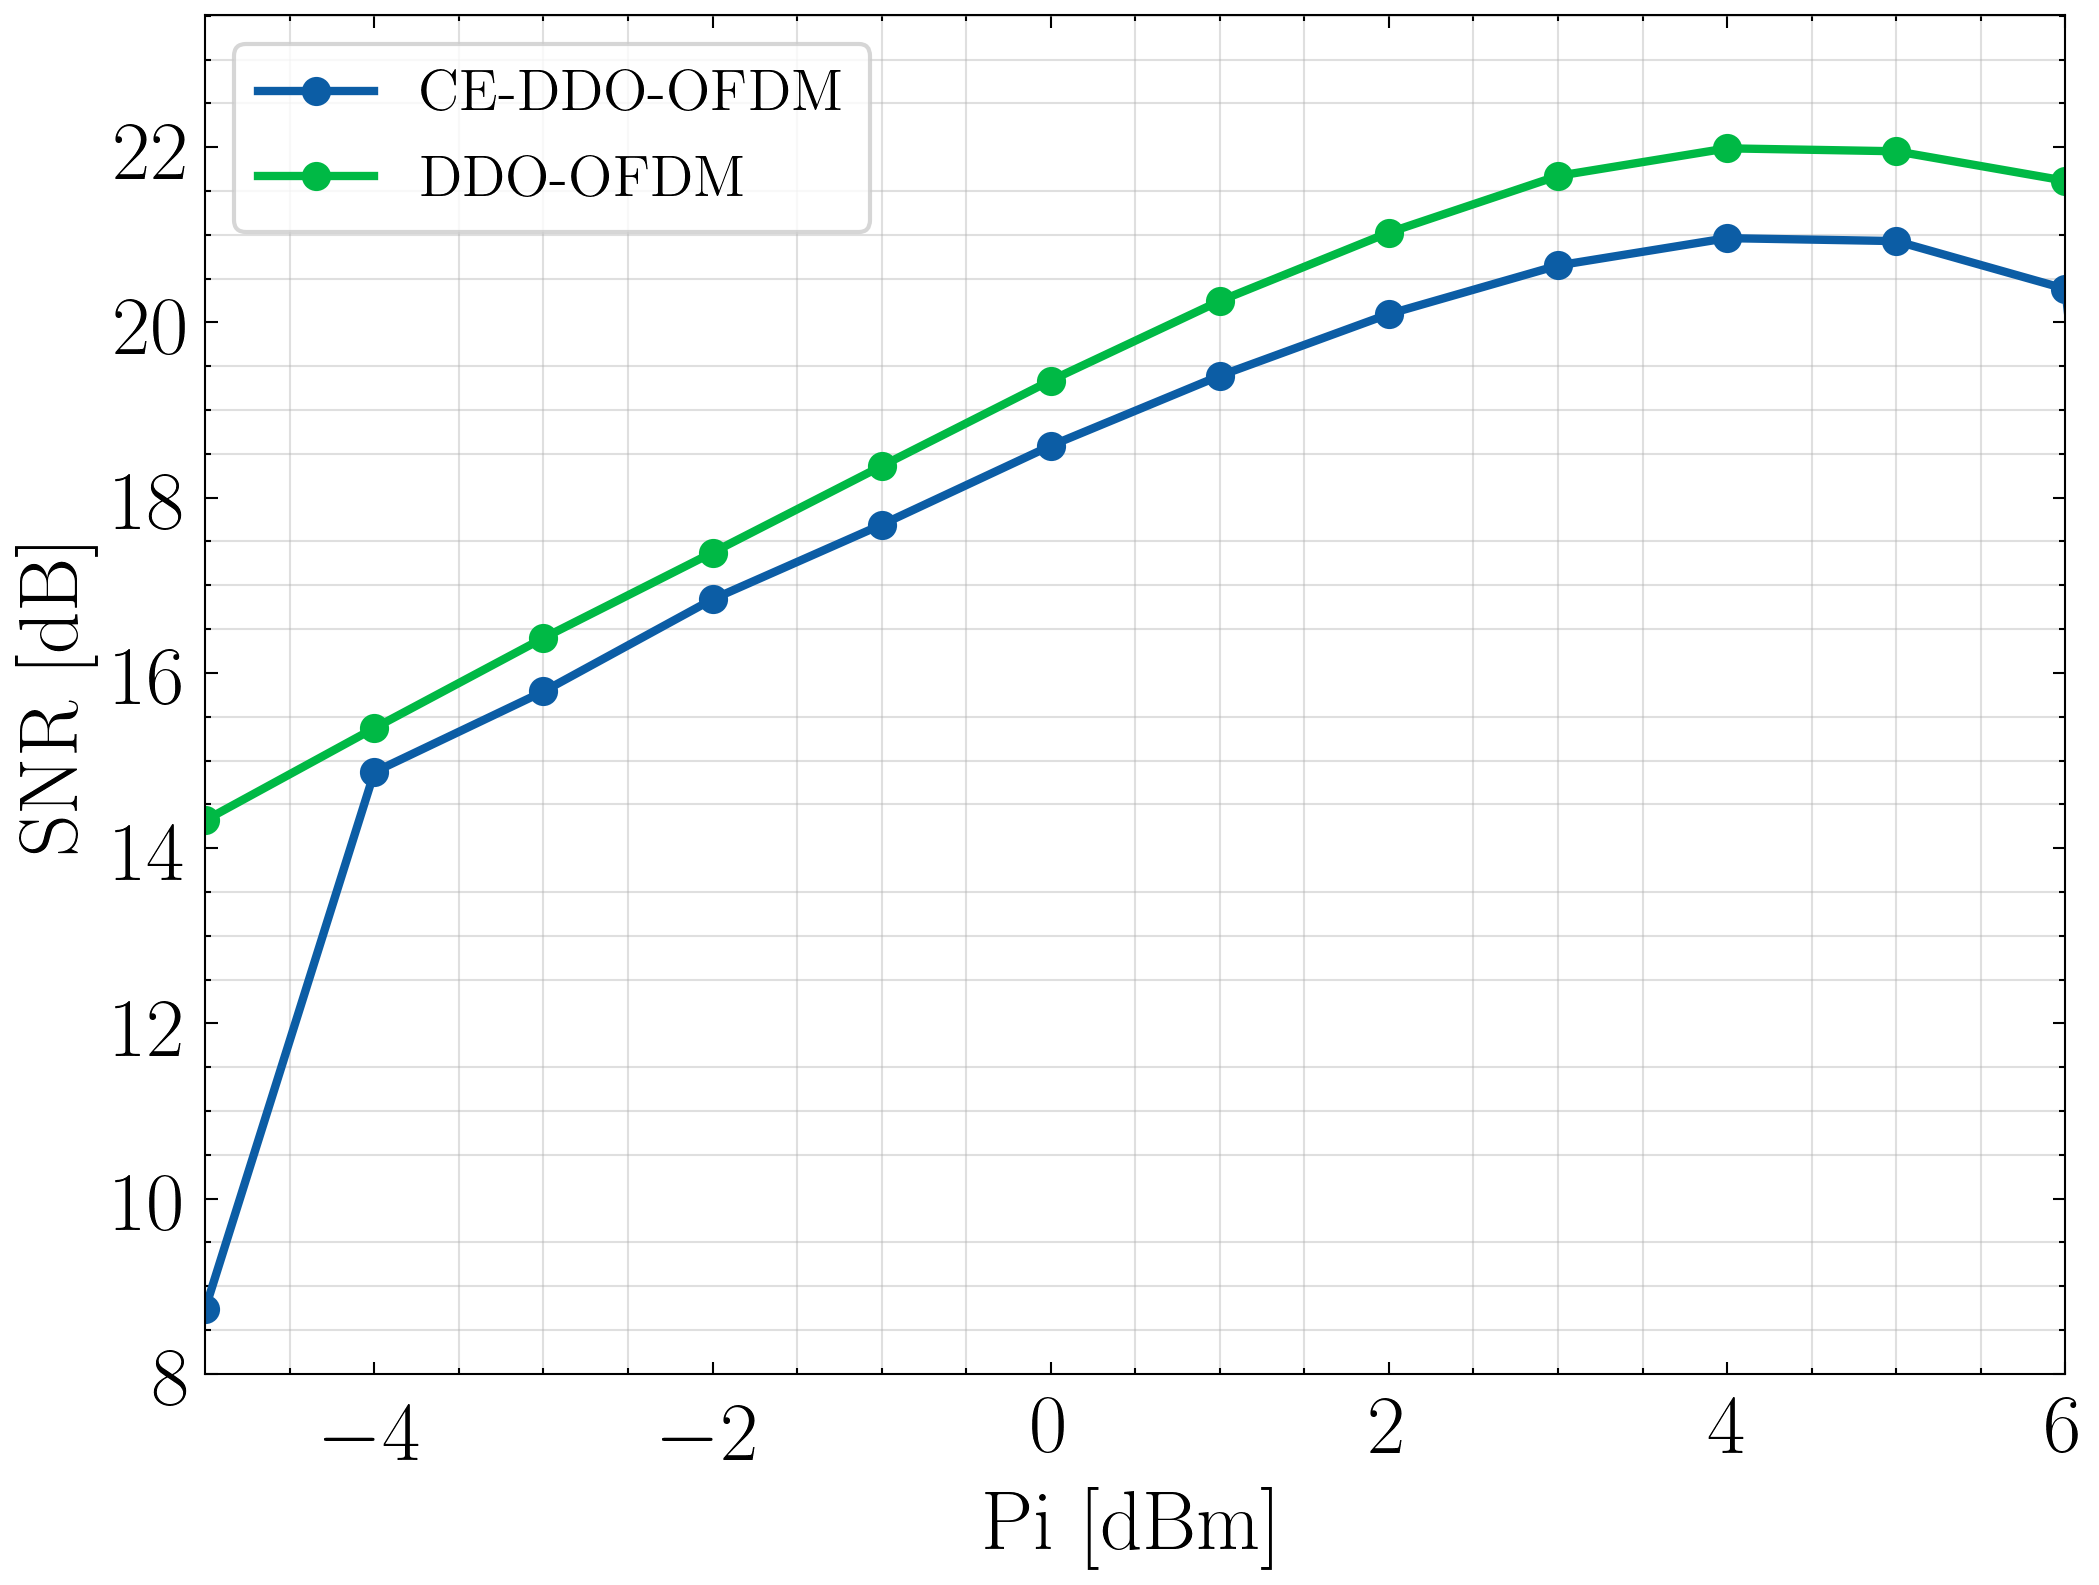

In [146]:
# BER vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, np.log10(BER_CEDD_Pi), '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Pi, np.log10(BER_DD_Pi), '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# SNR vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, SNR_CEDD_Pi, '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Pi, SNR_DD_Pi, '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"SNR [dB]")
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi),6)
plt.ylim(8)
plt.grid(which='minor', alpha=0.4)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


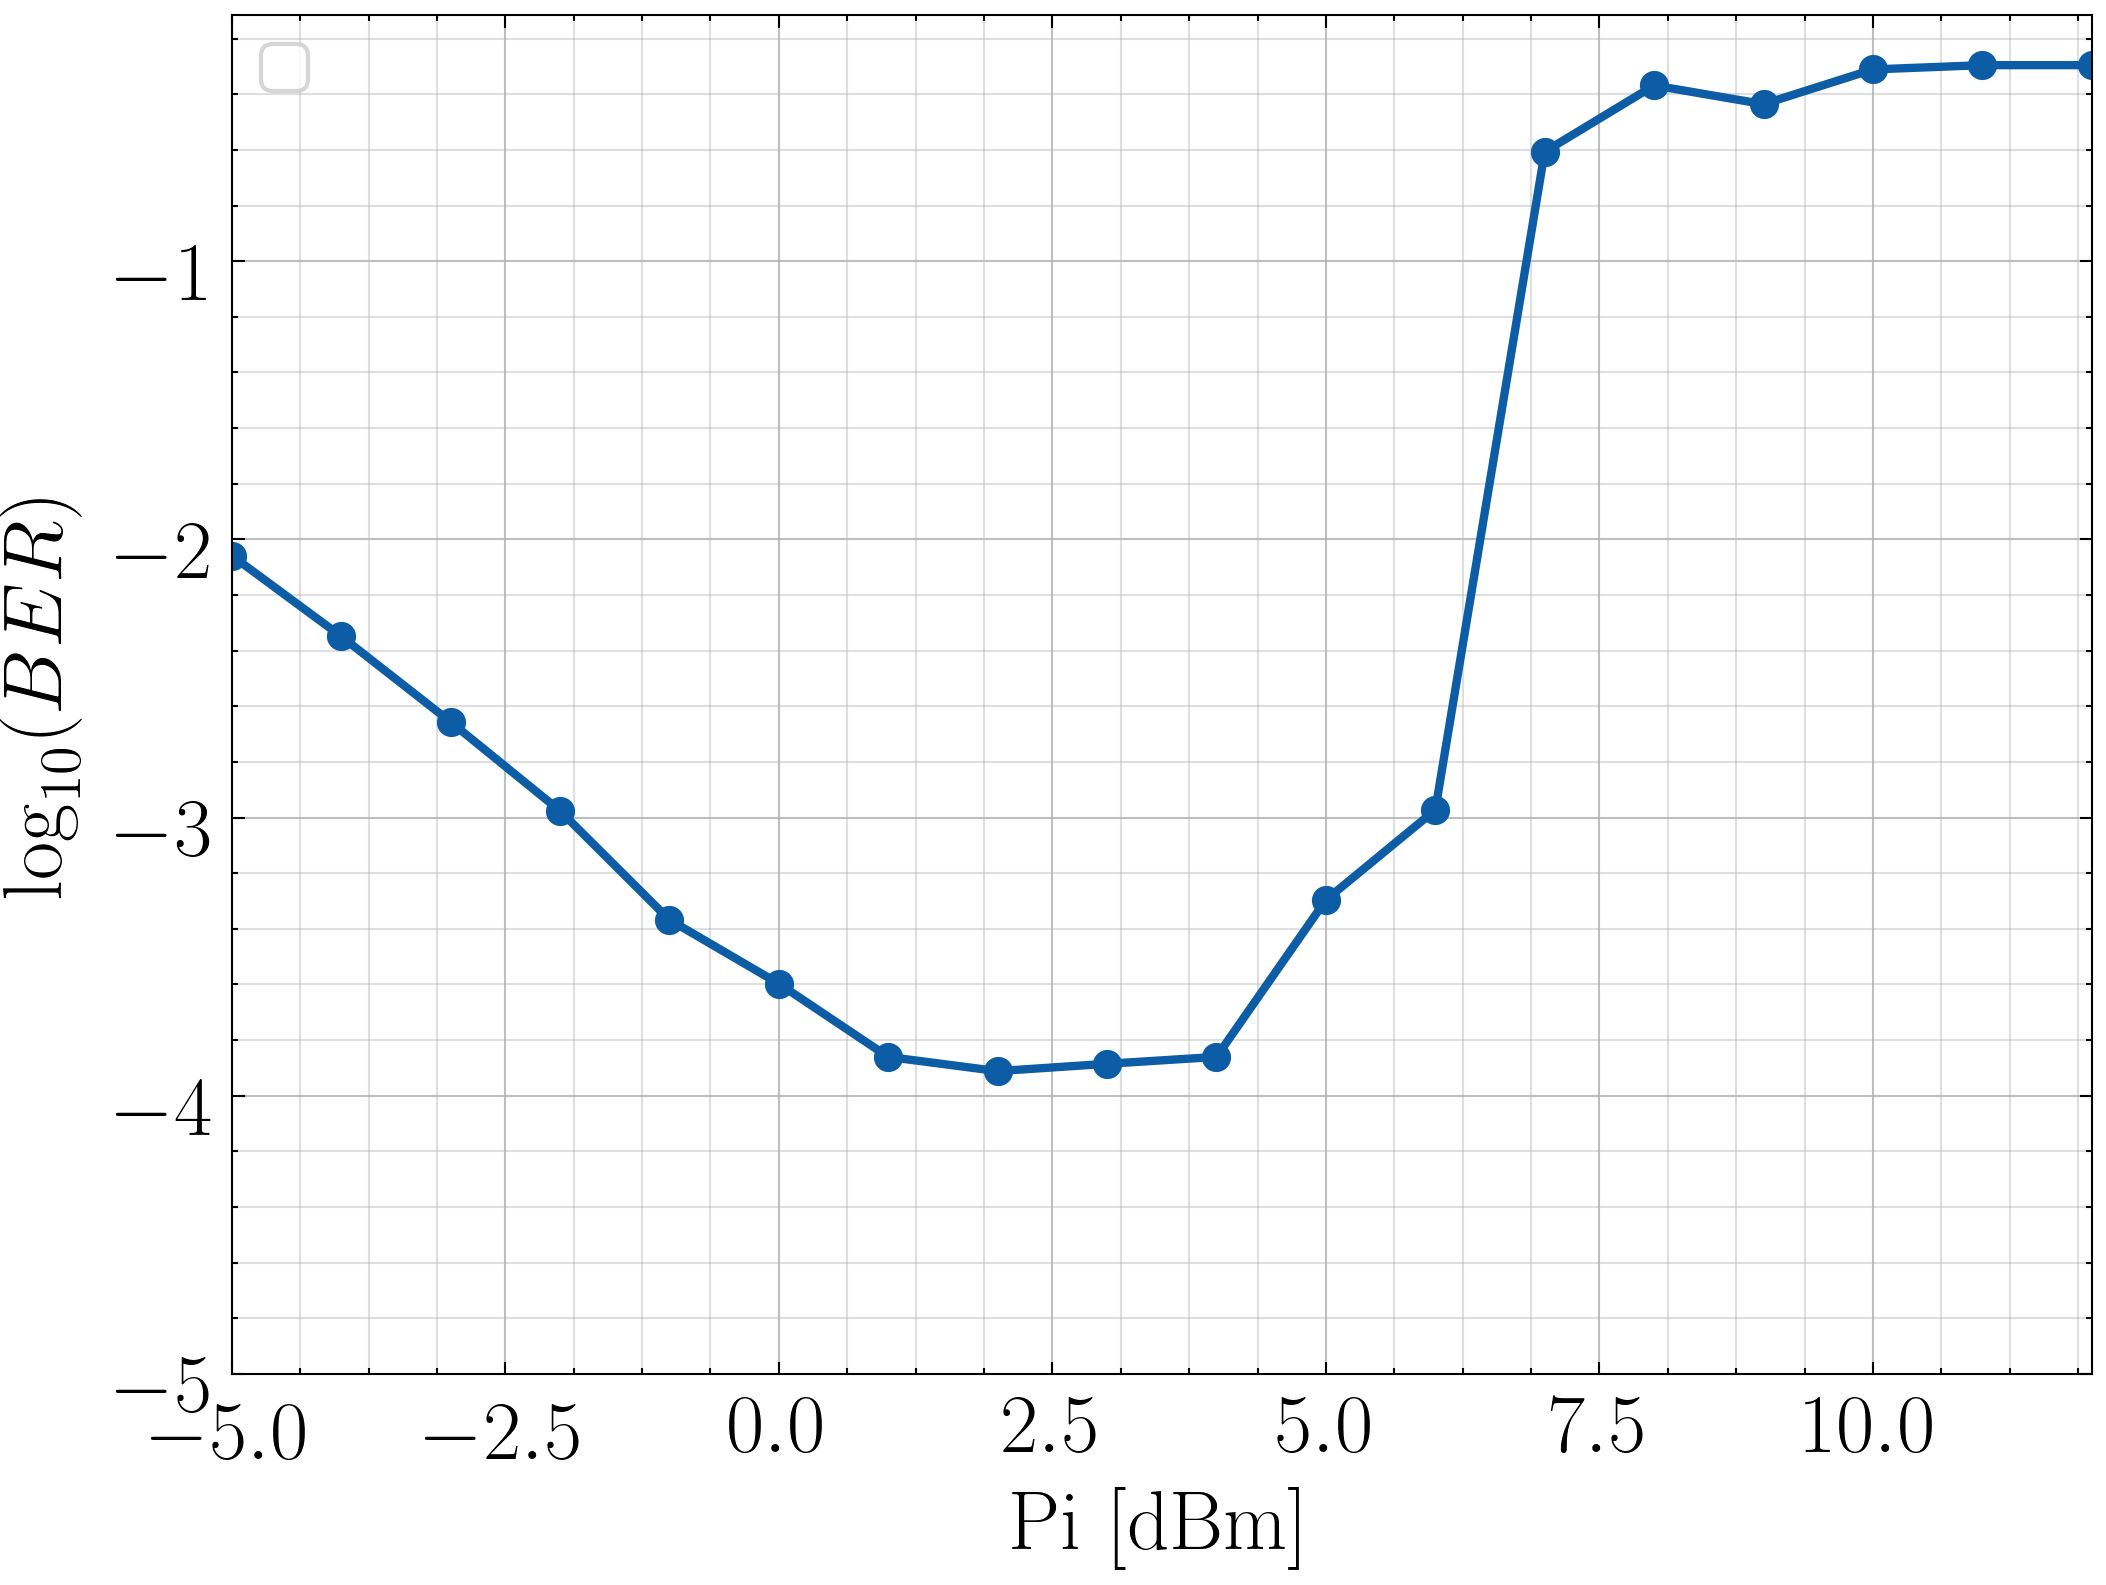

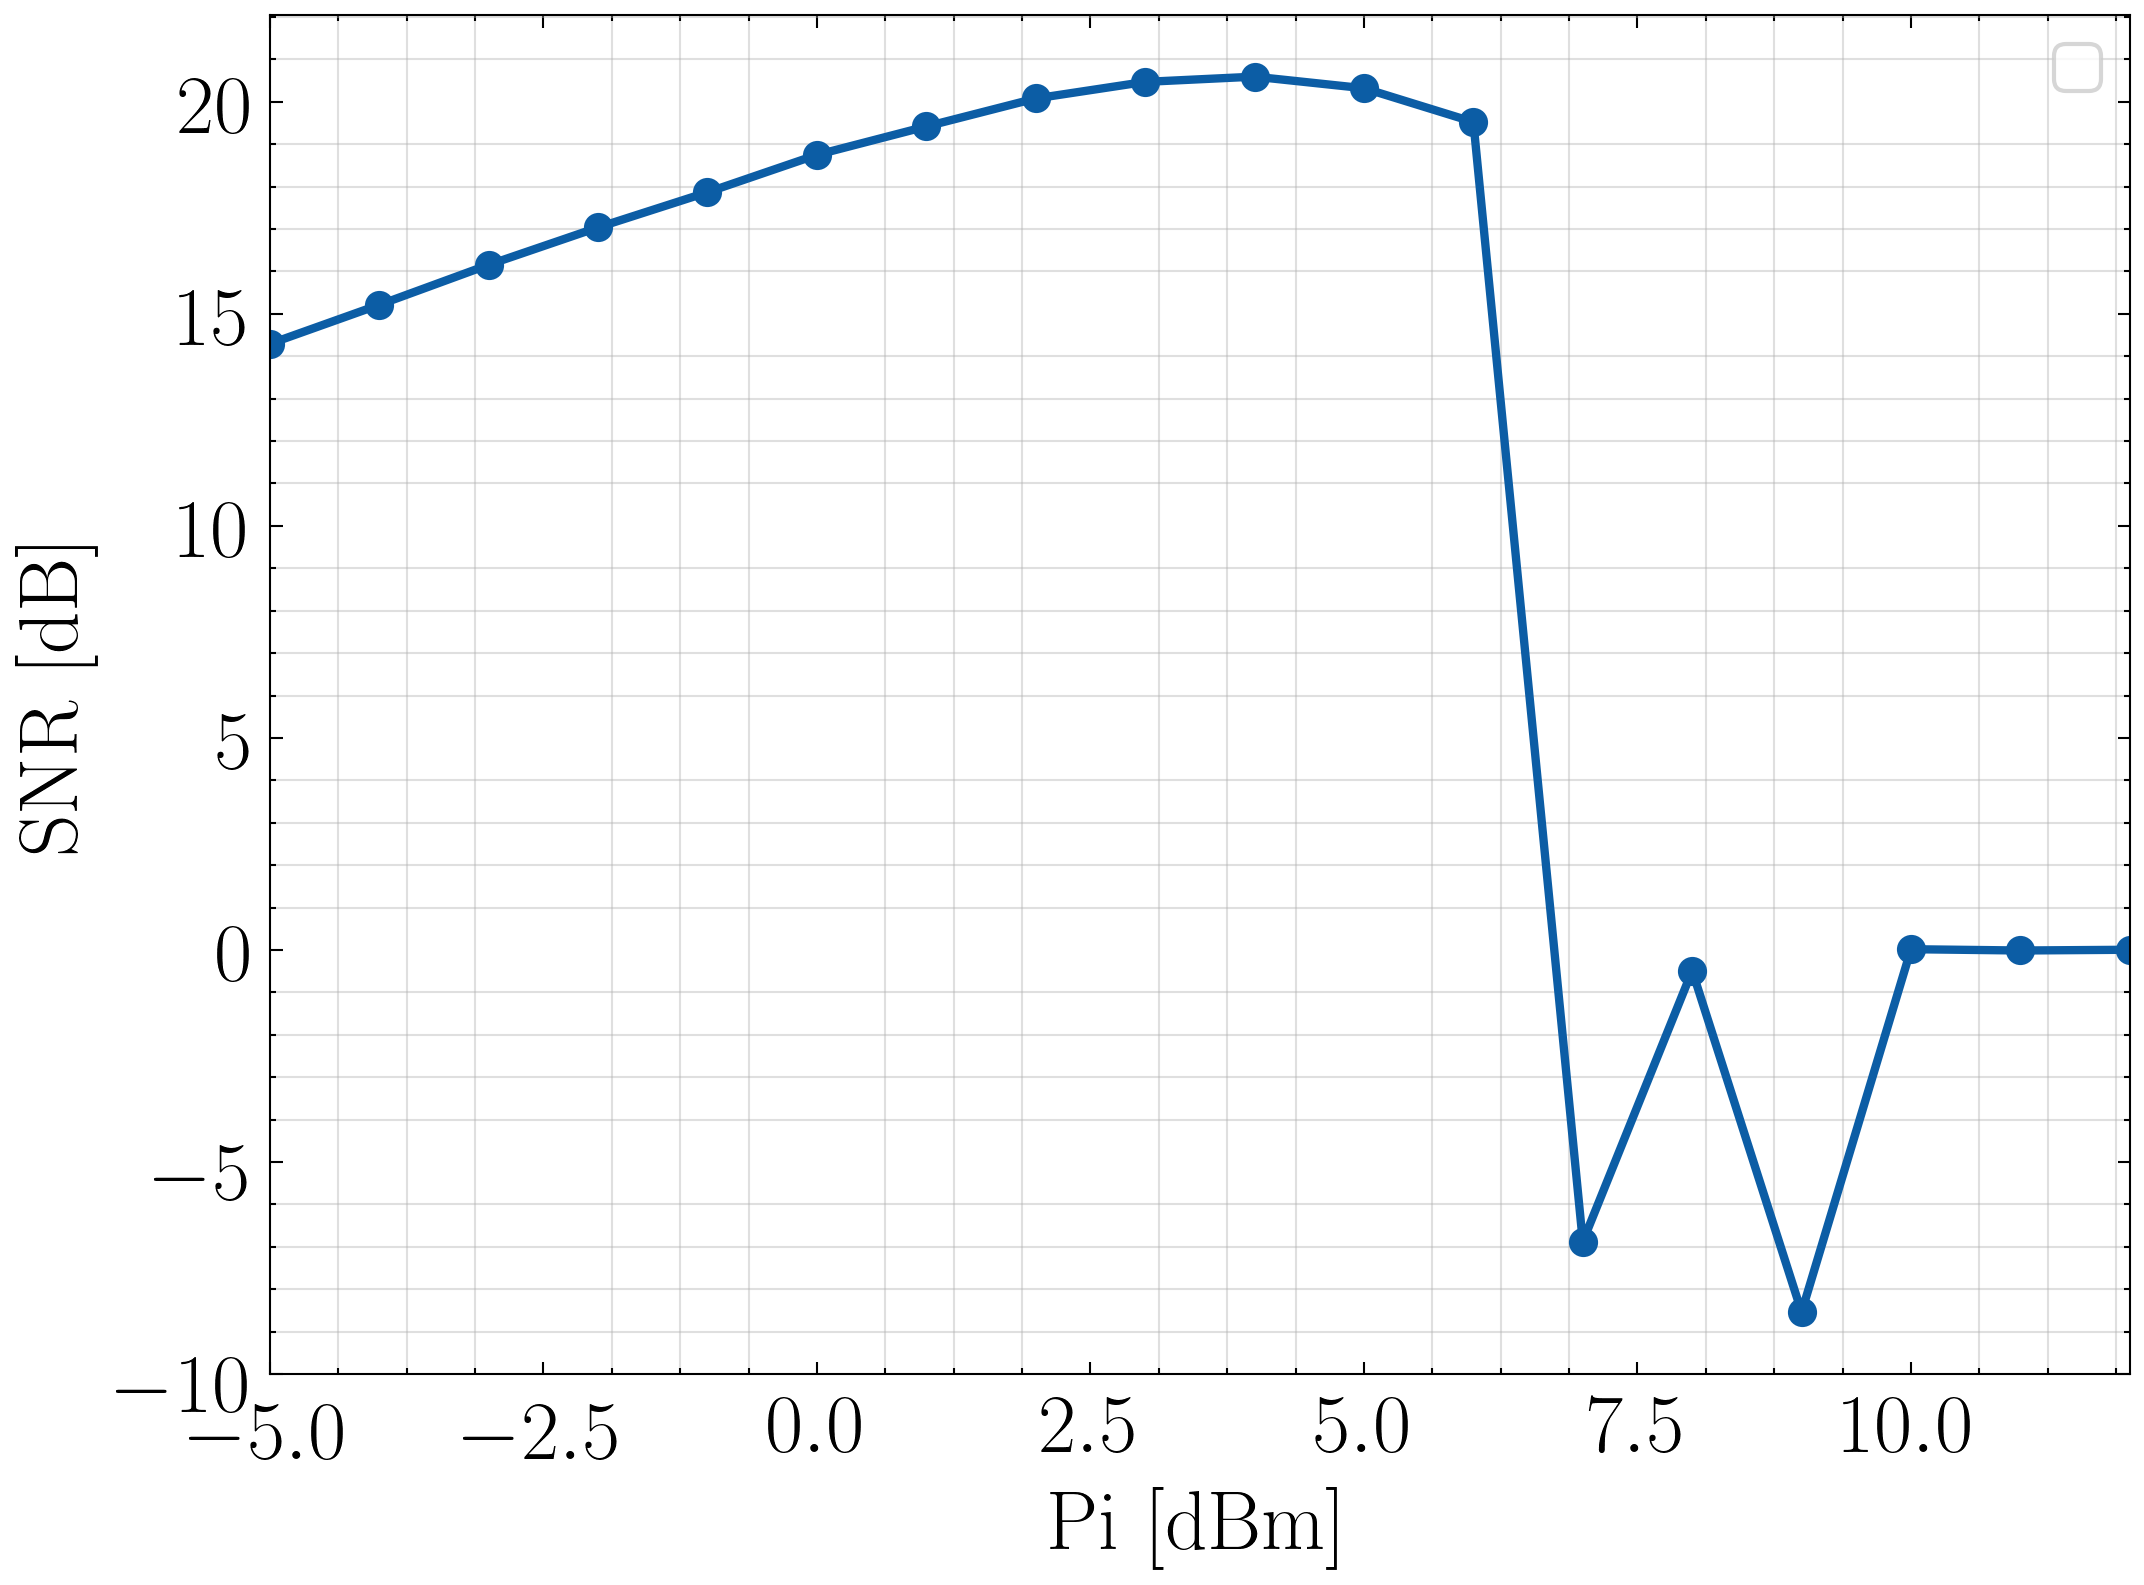

In [30]:
# BER vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, np.log10(BER_CEDD_Pi), '-o', ms = 6, lw = 2)
#plt.plot(Pi, np.log10(BER_DD_Pi), '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# SNR vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, SNR_CEDD_Pi, '-o', ms = 6, lw = 2)
#plt.plot(Pi, SNR_DD_Pi, '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"SNR [dB]")
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


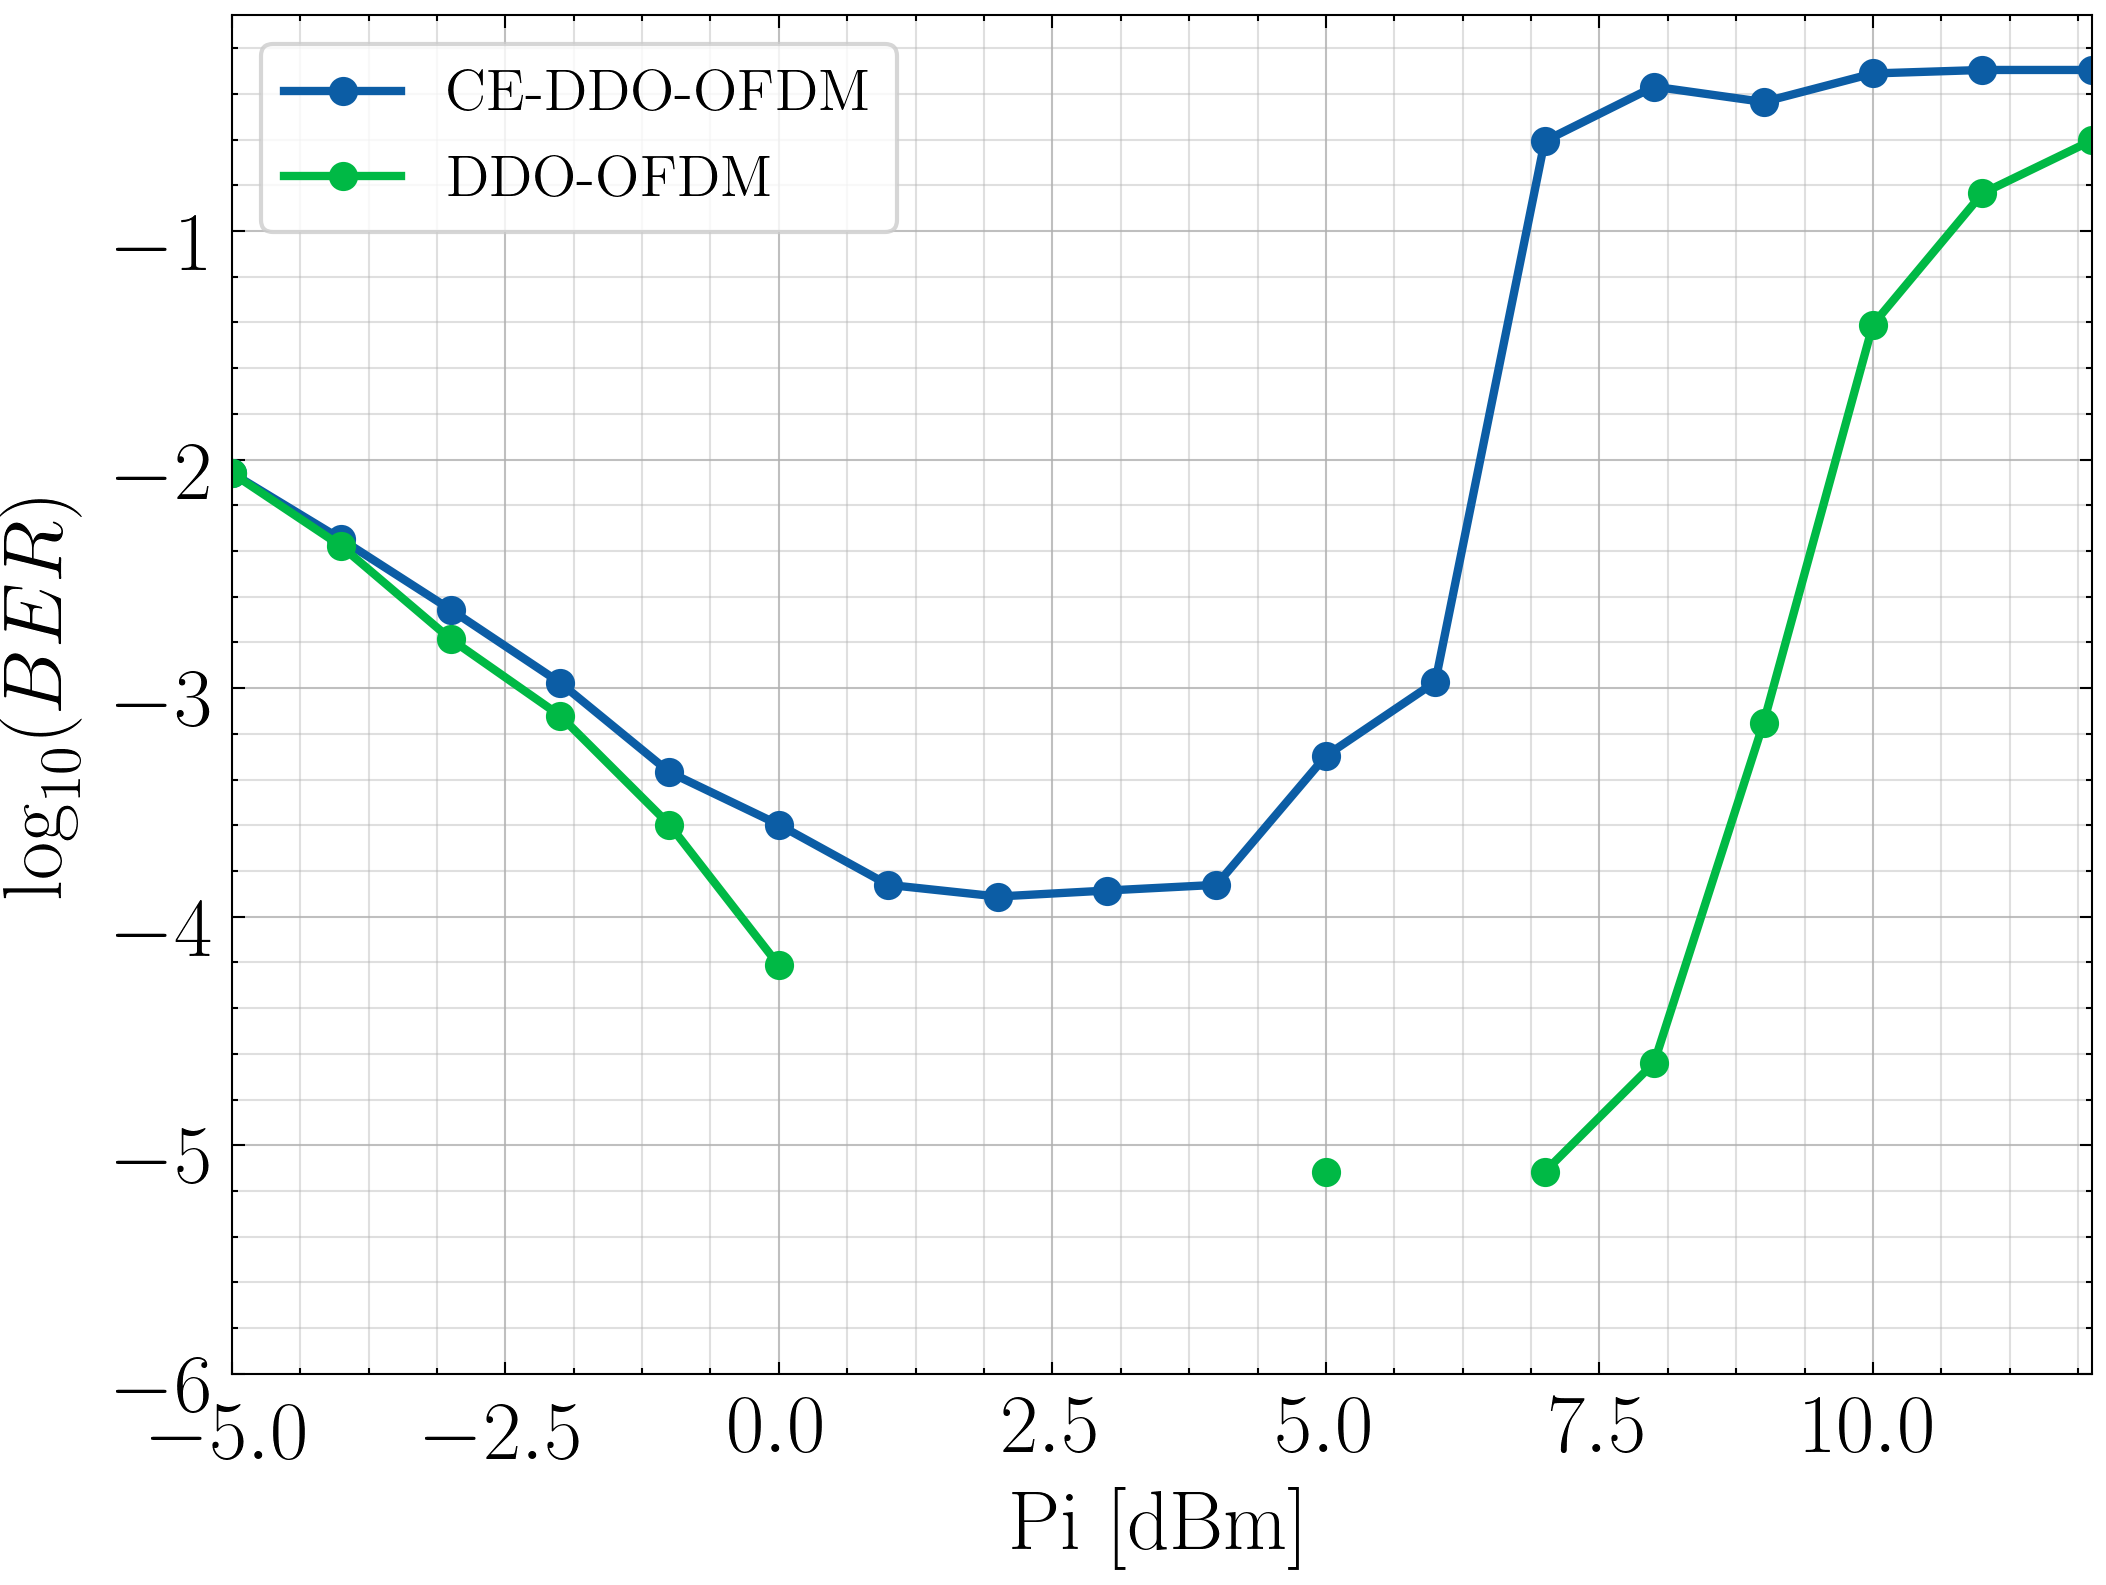

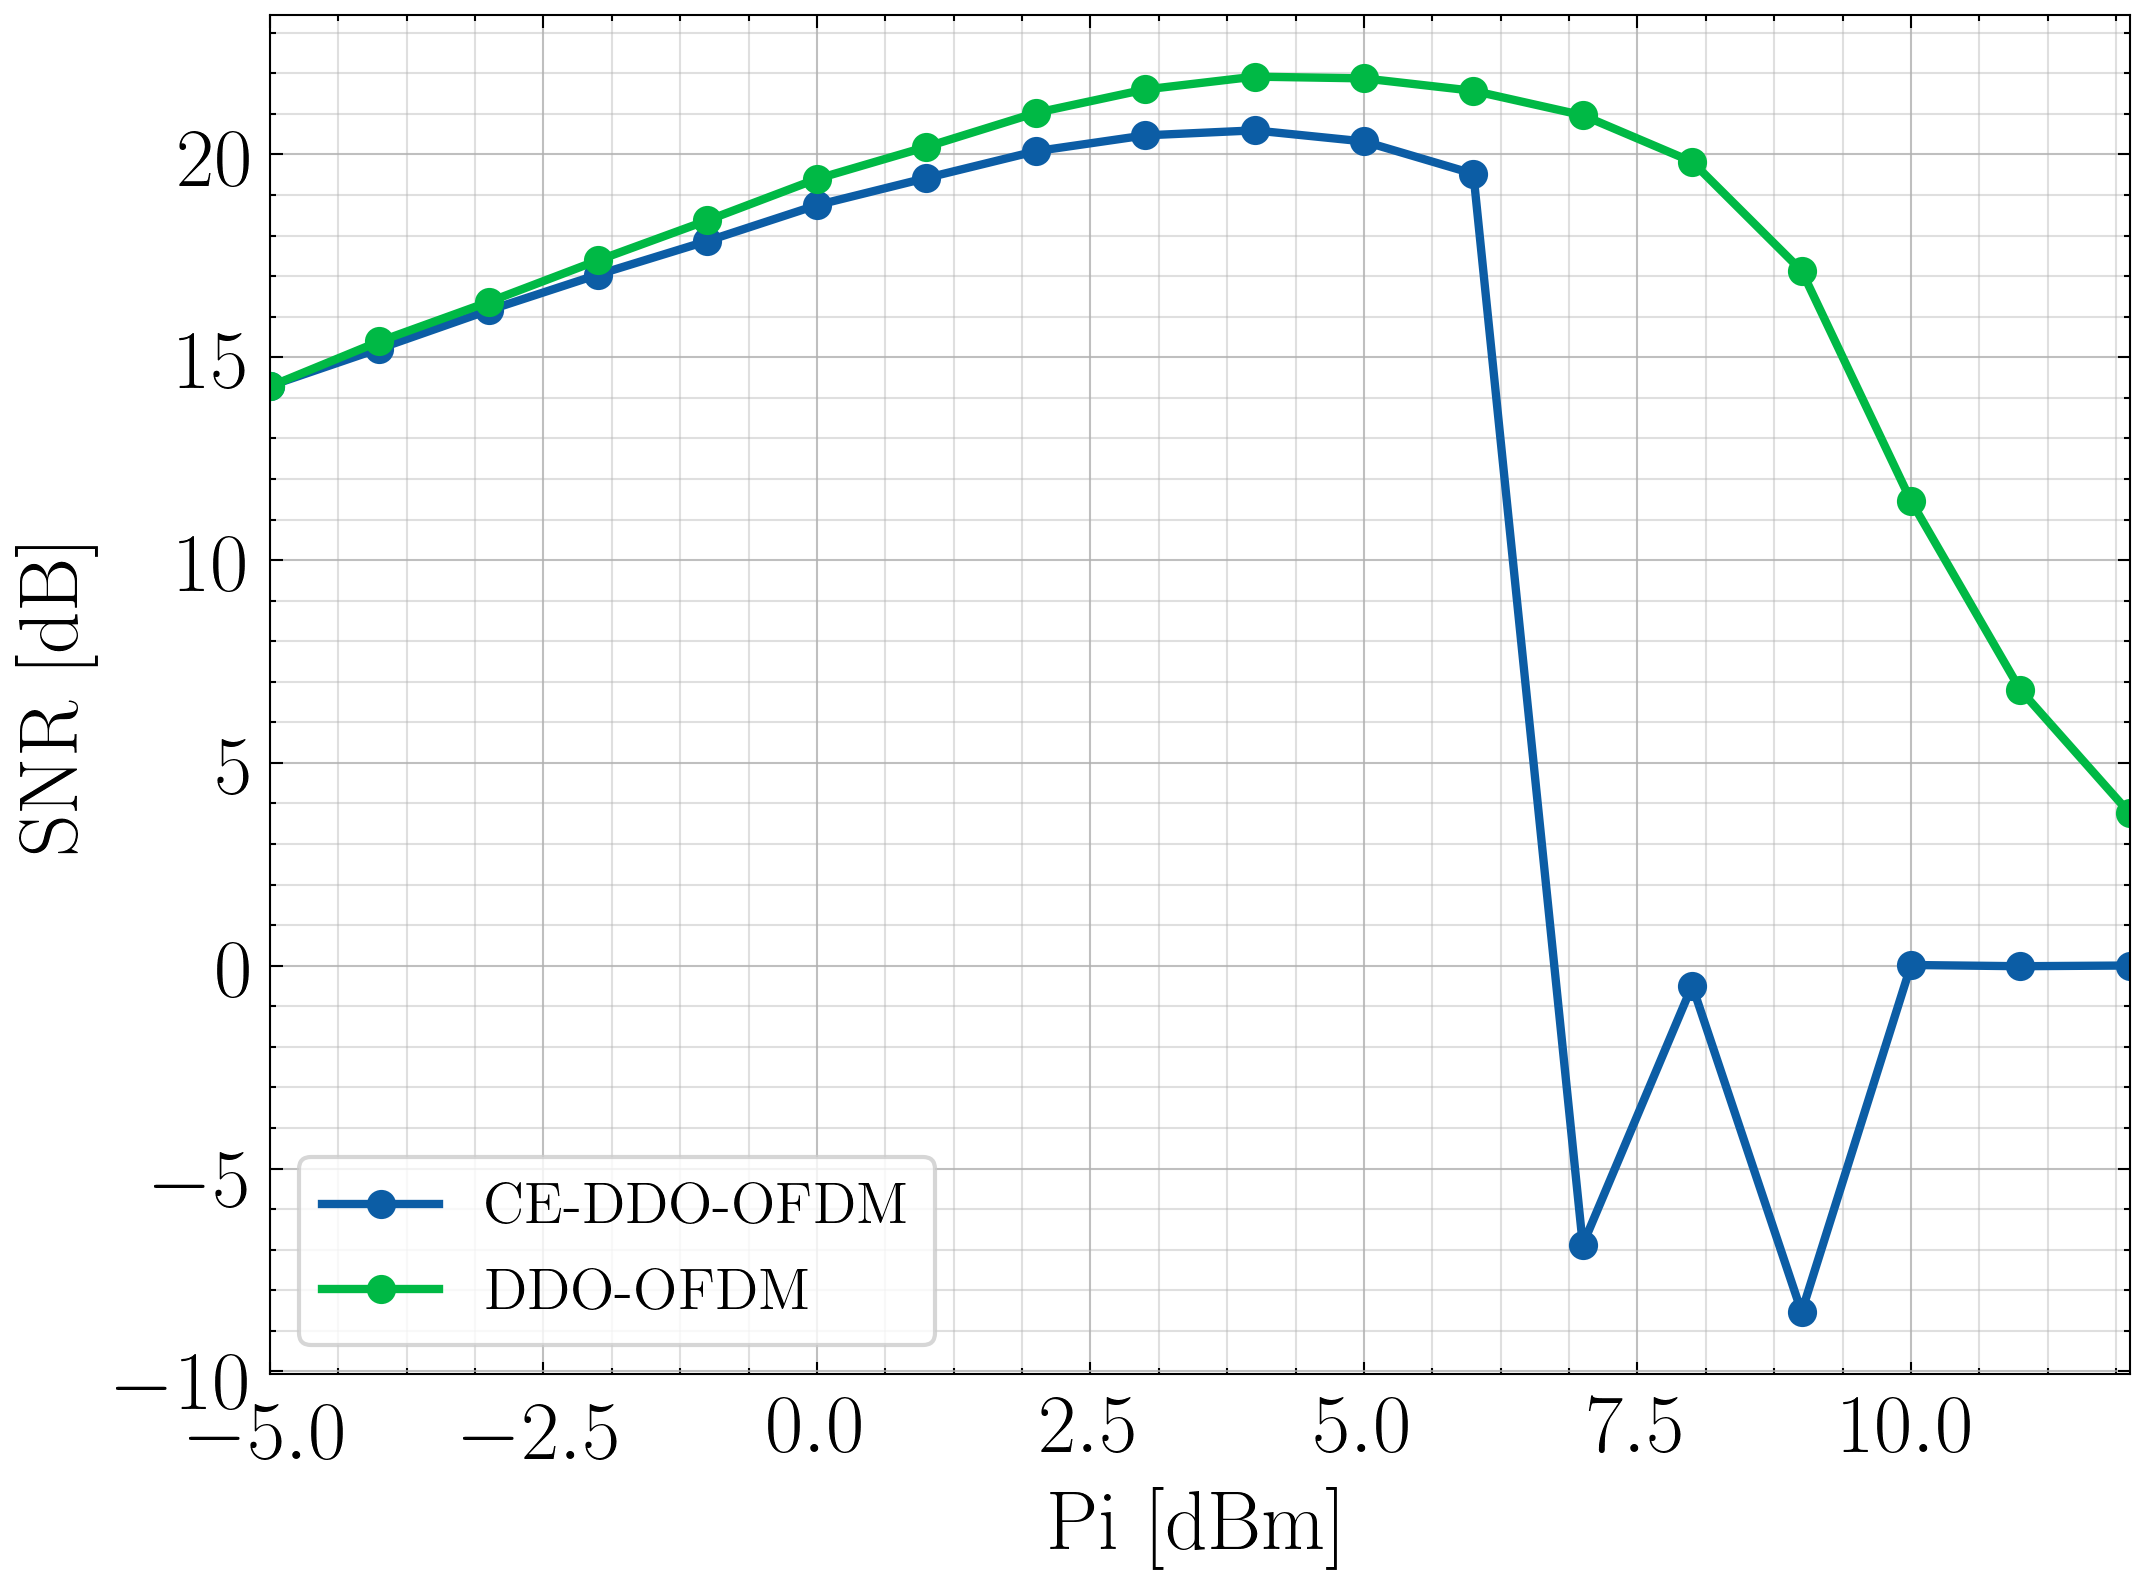

In [28]:
# BER vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, np.log10(BER_CEDD_Pi), '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Pi, np.log10(BER_DD_Pi), '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-6)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# SNR vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, SNR_CEDD_Pi, '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Pi, SNR_DD_Pi, '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"SNR [dB]")
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

In [158]:
paramTx.fc = 1e9
paramRx.fc = paramTx.fc
paramCh.Ltotal = 100

paramTx.H = 0.45/(2*pi)
paramRx.H = paramTx.H
paramTx.Vb = -0.5*paramTx.Vπ

Pi = np.arange(6, 10.5)

BER_CEDD_Pi2 = np.zeros(len(Pi))
SNR_CEDD_Pi2 = np.zeros(len(Pi))

paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(Pi))):
    paramTx.Pi_dBm = Pi[i]
    
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    sigRxo = sigTxo
    
    for j in range(7): # 700 km de fibra
        sigRxo,_  = ssfm(sigRxo, paramTx.Fa, paramCh)
        sigRxo = edc(sigRxo, paramCh.Ltotal, paramCh.D, paramTx.Fc, paramTx.Fa)
    
    ipd = photodiode(sigRxo, paramPD)
        
    symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
    BER_CEDD_Pi2[i], _, SNR_CEDD_Pi2[i] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')  

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
paramTx.Vb = -0.5*paramTx.Vπ

BER_DD_Pi2 = np.zeros(len(Pi))
SNR_DD_Pi2 = np.zeros(len(Pi))
paramTx.g = 0.5

paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(Pi))):
    paramTx.Pi_dBm = Pi[i]
        
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    sigRxo = sigTxo
    
    for j in range(7): # 700 km de fibra
        sigRxo,_  = ssfm(sigRxo, paramTx.Fa, paramCh)
        sigRxo = edc(sigRxo, paramCh.Ltotal, paramCh.D, paramTx.Fc, paramTx.Fa)
    
    ipd = photodiode(sigRxo, paramPD)
    
    symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)    
    BER_DD_Pi2[i], _, SNR_DD_Pi2[i] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')   

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


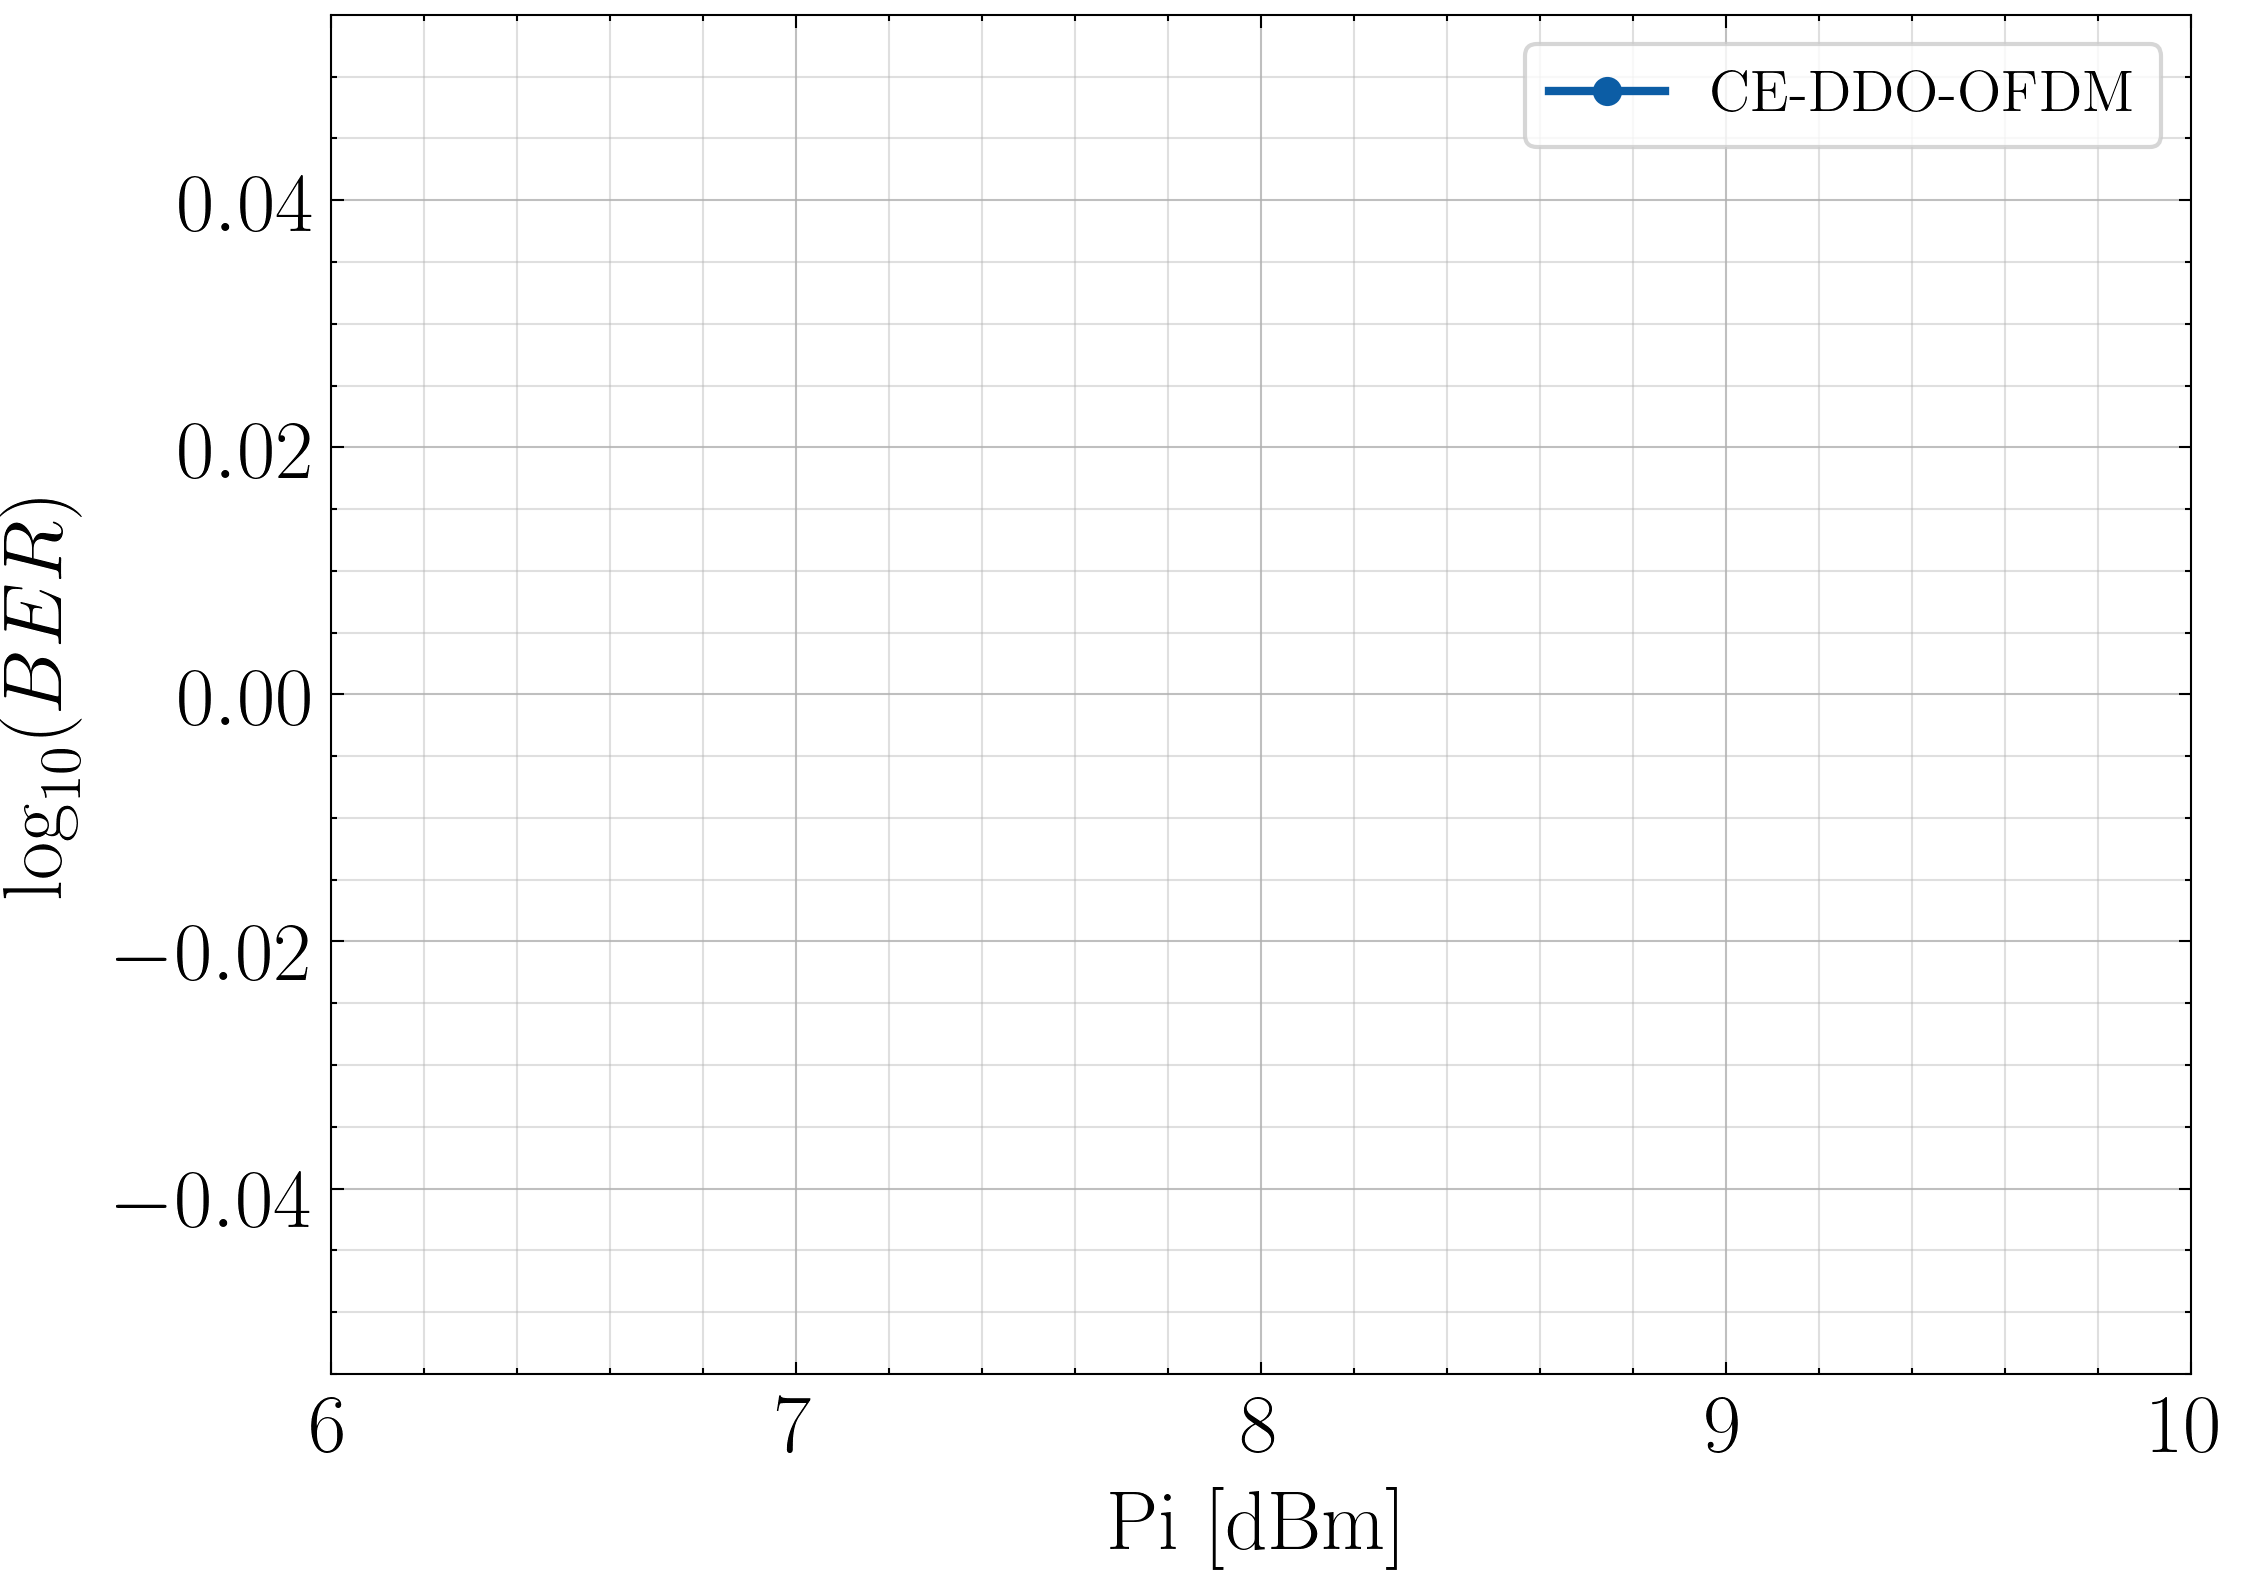

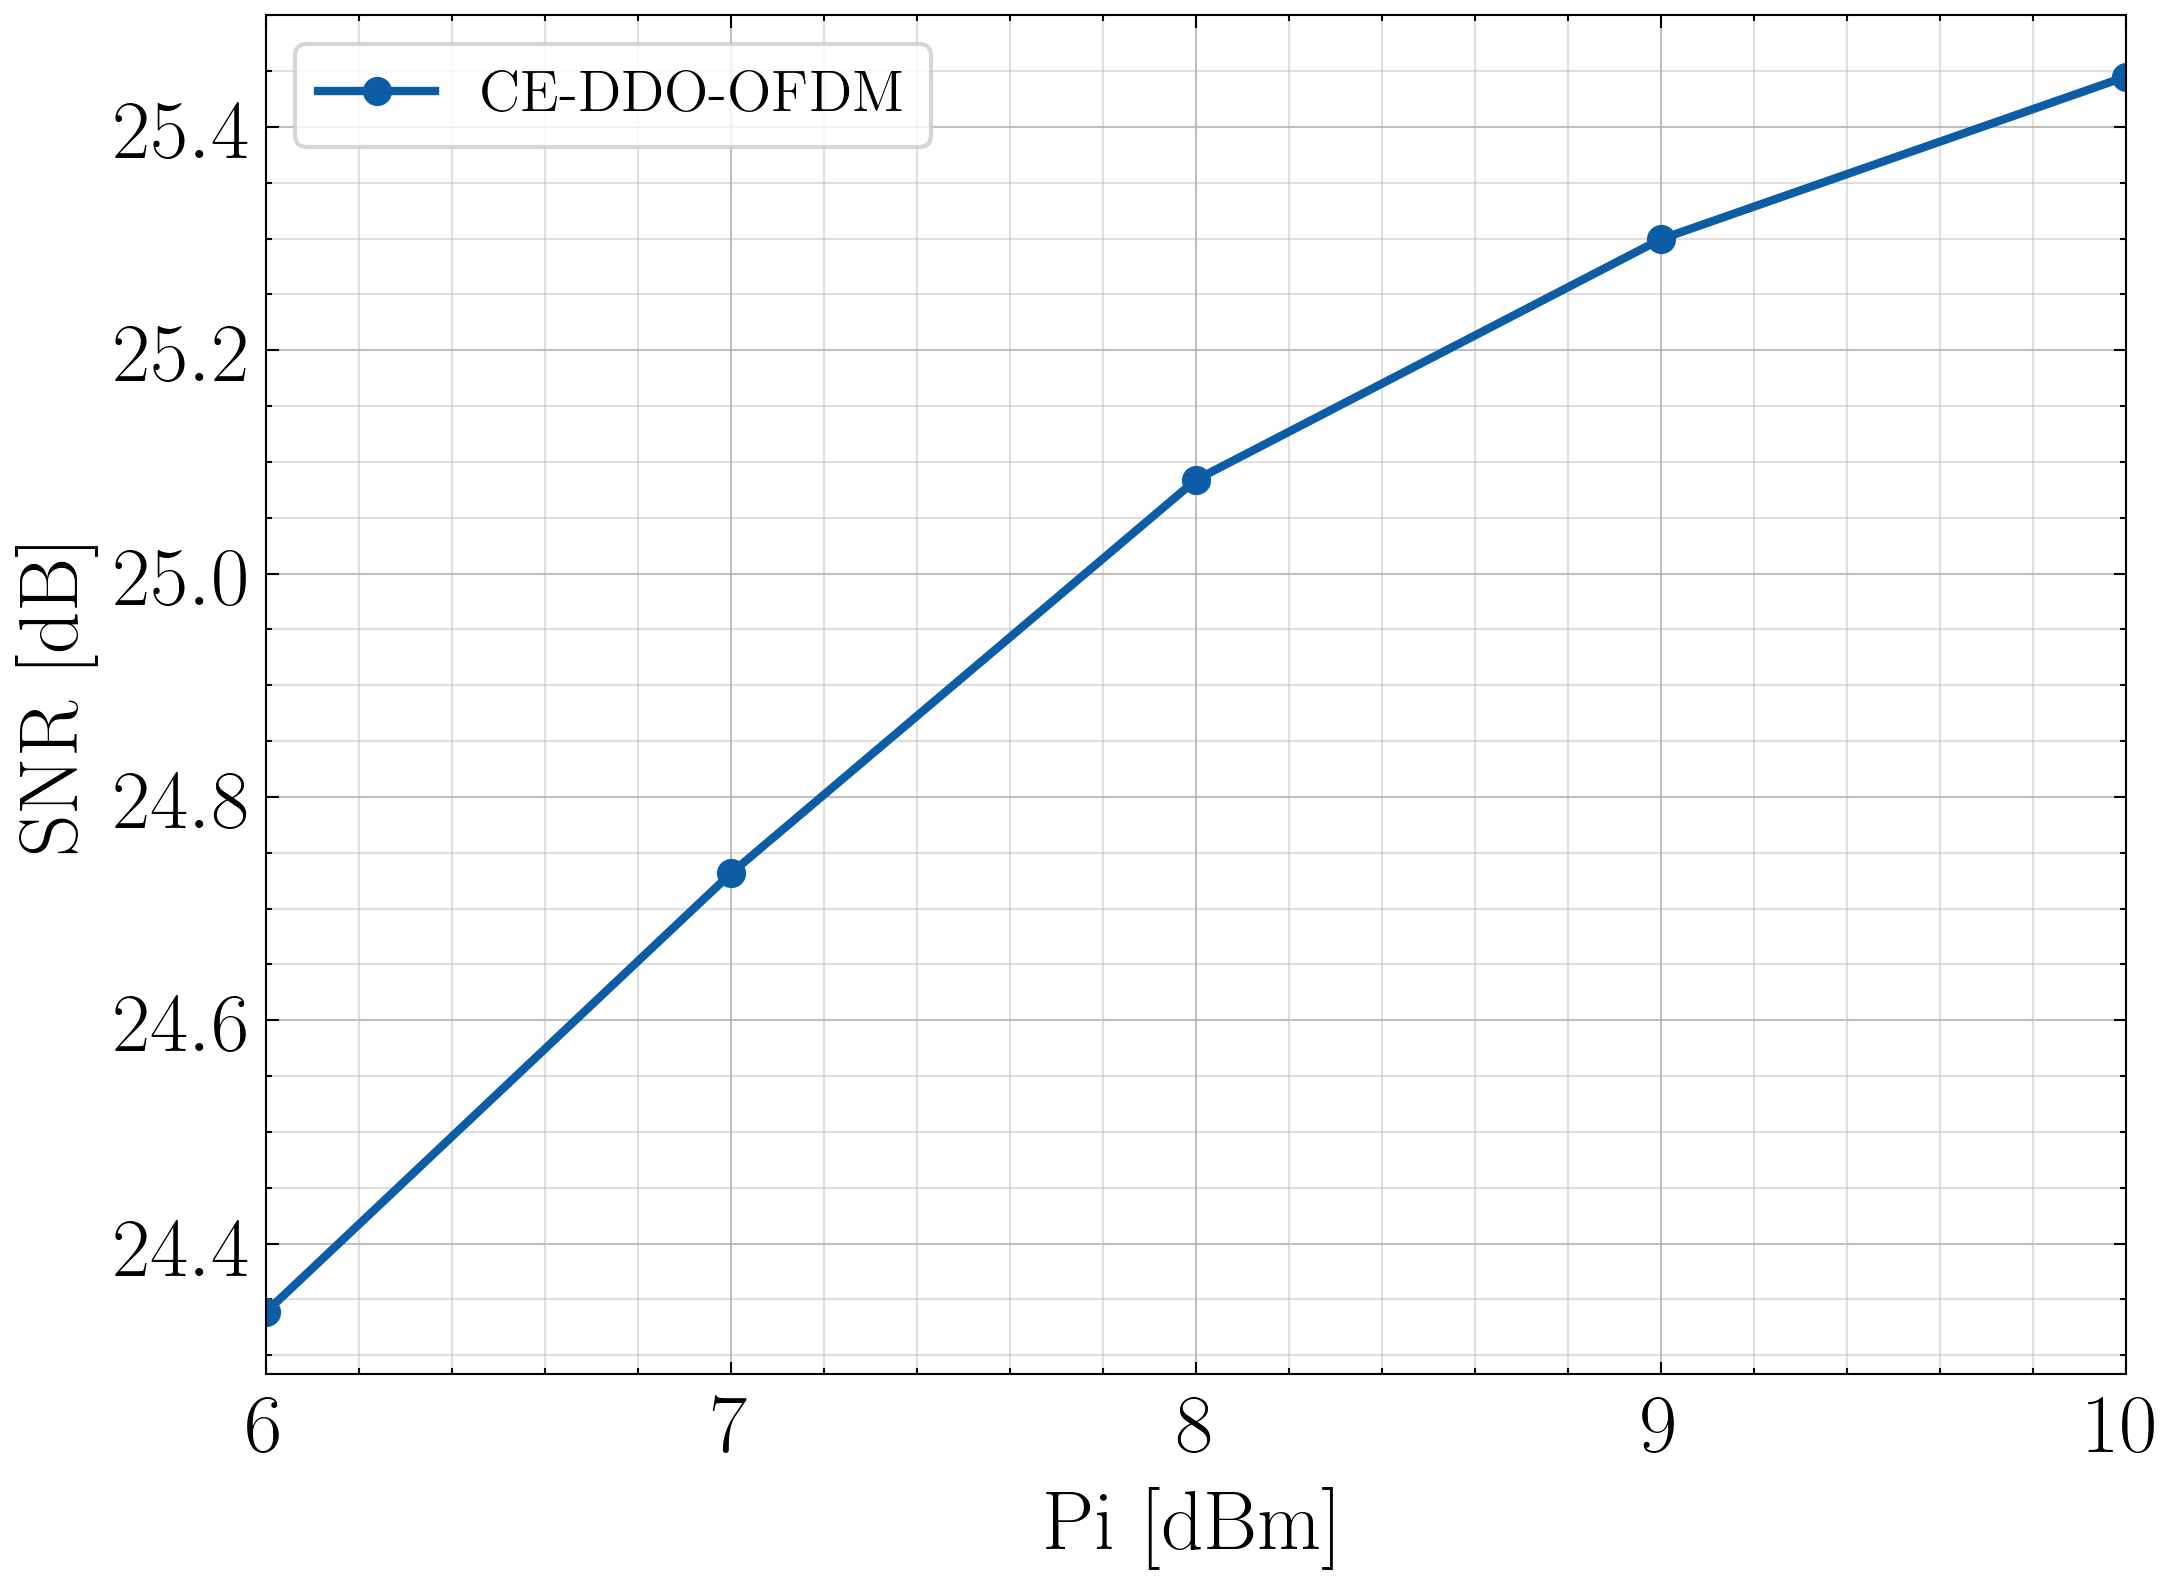

In [161]:
# BER vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, np.log10(BER_CEDD_Pi2), '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
#plt.plot(Pi, np.log10(BER_DD_Pi2), '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"$\log_{10}(BER)$")
#plt.ylim(-6)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# SNR vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, SNR_CEDD_Pi2, '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
#plt.plot(Pi, SNR_DD_Pi2, '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"SNR [dB]")
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

In [164]:
Int = int(paramTx.N/paramTx.K)
carriers = np.arange(0, paramTx.N)
pilot_carriers = np.append(carriers[0::Int], carriers[-1])

In [195]:
paramCh.hz = 0.5

In [197]:
paramTx.fc = 1e9
paramRx.fc = paramTx.fc
paramCh.Ltotal = 100

L = np.arange(100, 5100, 100)
Pi = np.array([0, 2, 8, 10])
paramTx.H = 0.45/(2*pi)
paramRx.H = paramTx.H
paramTx.Vb = -0.5*paramTx.Vπ

BER_CEDD_L = np.zeros((len(Pi), len(L)))
SNR_CEDD_L = np.zeros((len(Pi), len(L)))

BER_CEDD_Leq = np.zeros((len(Pi), len(L)))
SNR_CEDD_Leq = np.zeros((len(Pi), len(L)))

paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in range(len(Pi)):
    paramTx.Pi_dBm = Pi[i]
    
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    sigRxo = sigTxo.copy()
    sigRxo_eq = sigTxo.copy()
        
    aux = 0
    for r in range(int(len(symbTx)/paramTx.N)):
        symbTx[aux:aux+paramTx.N][pilot_carriers] = np.nan
        aux += paramTx.N

    symbTx = symbTx[~np.isnan(symbTx)]
    
    for j in tqdm(range(len(L))):
        sigRxo,_  = ssfm(sigRxo, paramTx.Fa, paramCh)
        
        sigRxo_eq,_ = ssfm(sigRxo_eq, paramTx.Fa, paramCh)
        sigRxo_eq = edc(sigRxo_eq, paramCh.Ltotal, paramCh.D, paramTx.Fc, paramTx.Fa)

        ipd = photodiode(sigRxo, paramPD)
        ipd_eq = photodiode(sigRxo_eq, paramPD)
        
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        # Sem compensação
        aux = 0
        for r in range(int(len(symbRx)/paramTx.N)):
            symbRx[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbRx = symbRx[~np.isnan(symbRx)]
        
        discard = 100
        ind = np.arange(discard, len(symbRx)-discard)
        
        BER_CEDD_L[i,j], _, SNR_CEDD_L[i,j] = fastBERcalc(symbRx[ind], symbTx[ind], paramTx.M, 'qam') 
        
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd_eq, pilot, pulse, t, paramRx)
        
        # Com compensação
        aux = 0
        for r in range(int(len(symbRx)/paramTx.N)):
            symbRx[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbRx = symbRx[~np.isnan(symbRx)]
        
        BER_CEDD_Leq[i,j], _, SNR_CEDD_Leq[i,j] = fastBERcalc(symbRx[ind], symbTx[ind], paramTx.M, 'qam') 

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [198]:
paramTx.fc = 1e9
paramRx.fc = paramTx.fc
paramCh.Ltotal = 100

L = np.arange(100, 5100, 100)
Pi = np.array([0, 2, 8, 10])
paramTx.g = 0.5
paramTx.Vb = -0.5*paramTx.Vπ

BER_DD_L = np.zeros((len(Pi), len(L)))
SNR_DD_L = np.zeros((len(Pi), len(L)))

BER_DD_Leq = np.zeros((len(Pi), len(L)))
SNR_DD_Leq = np.zeros((len(Pi), len(L)))

paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in range(len(Pi)):
    paramTx.Pi_dBm = Pi[i]
    
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    sigRxo = sigTxo.copy()
    sigRxo_eq = sigTxo.copy()
        
    aux = 0
    for r in range(int(len(symbTx)/paramTx.N)):
        symbTx[aux:aux+paramTx.N][pilot_carriers] = np.nan
        aux += paramTx.N

    symbTx = symbTx[~np.isnan(symbTx)]
    
    for j in tqdm(range(len(L))):
        sigRxo,_  = ssfm(sigRxo, paramTx.Fa, paramCh)
        
        sigRxo_eq,_ = ssfm(sigRxo_eq, paramTx.Fa, paramCh)
        sigRxo_eq = edc(sigRxo_eq, paramCh.Ltotal, paramCh.D, paramTx.Fc, paramTx.Fa)

        ipd = photodiode(sigRxo, paramPD)
        ipd_eq = photodiode(sigRxo_eq, paramPD)
        
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        # Sem compensação
        aux = 0
        for r in range(int(len(symbRx)/paramTx.N)):
            symbRx[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbRx = symbRx[~np.isnan(symbRx)]
        
        discard = 100
        ind = np.arange(discard, len(symbRx)-discard)
        
        BER_DD_L[i,j], _, SNR_DD_L[i,j] = fastBERcalc(symbRx[ind], symbTx[ind], paramTx.M, 'qam') 
        
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd_eq, pilot, pulse, t, paramRx)
        
        # Com compensação
        aux = 0
        for r in range(int(len(symbRx)/paramTx.N)):
            symbRx[aux:aux+paramTx.N][pilot_carriers] = np.nan
            aux += paramTx.N
        symbRx = symbRx[~np.isnan(symbRx)]
        
        BER_DD_Leq[i,j], _, SNR_DD_Leq[i,j] = fastBERcalc(symbRx[ind], symbTx[ind], paramTx.M, 'qam') 

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered 

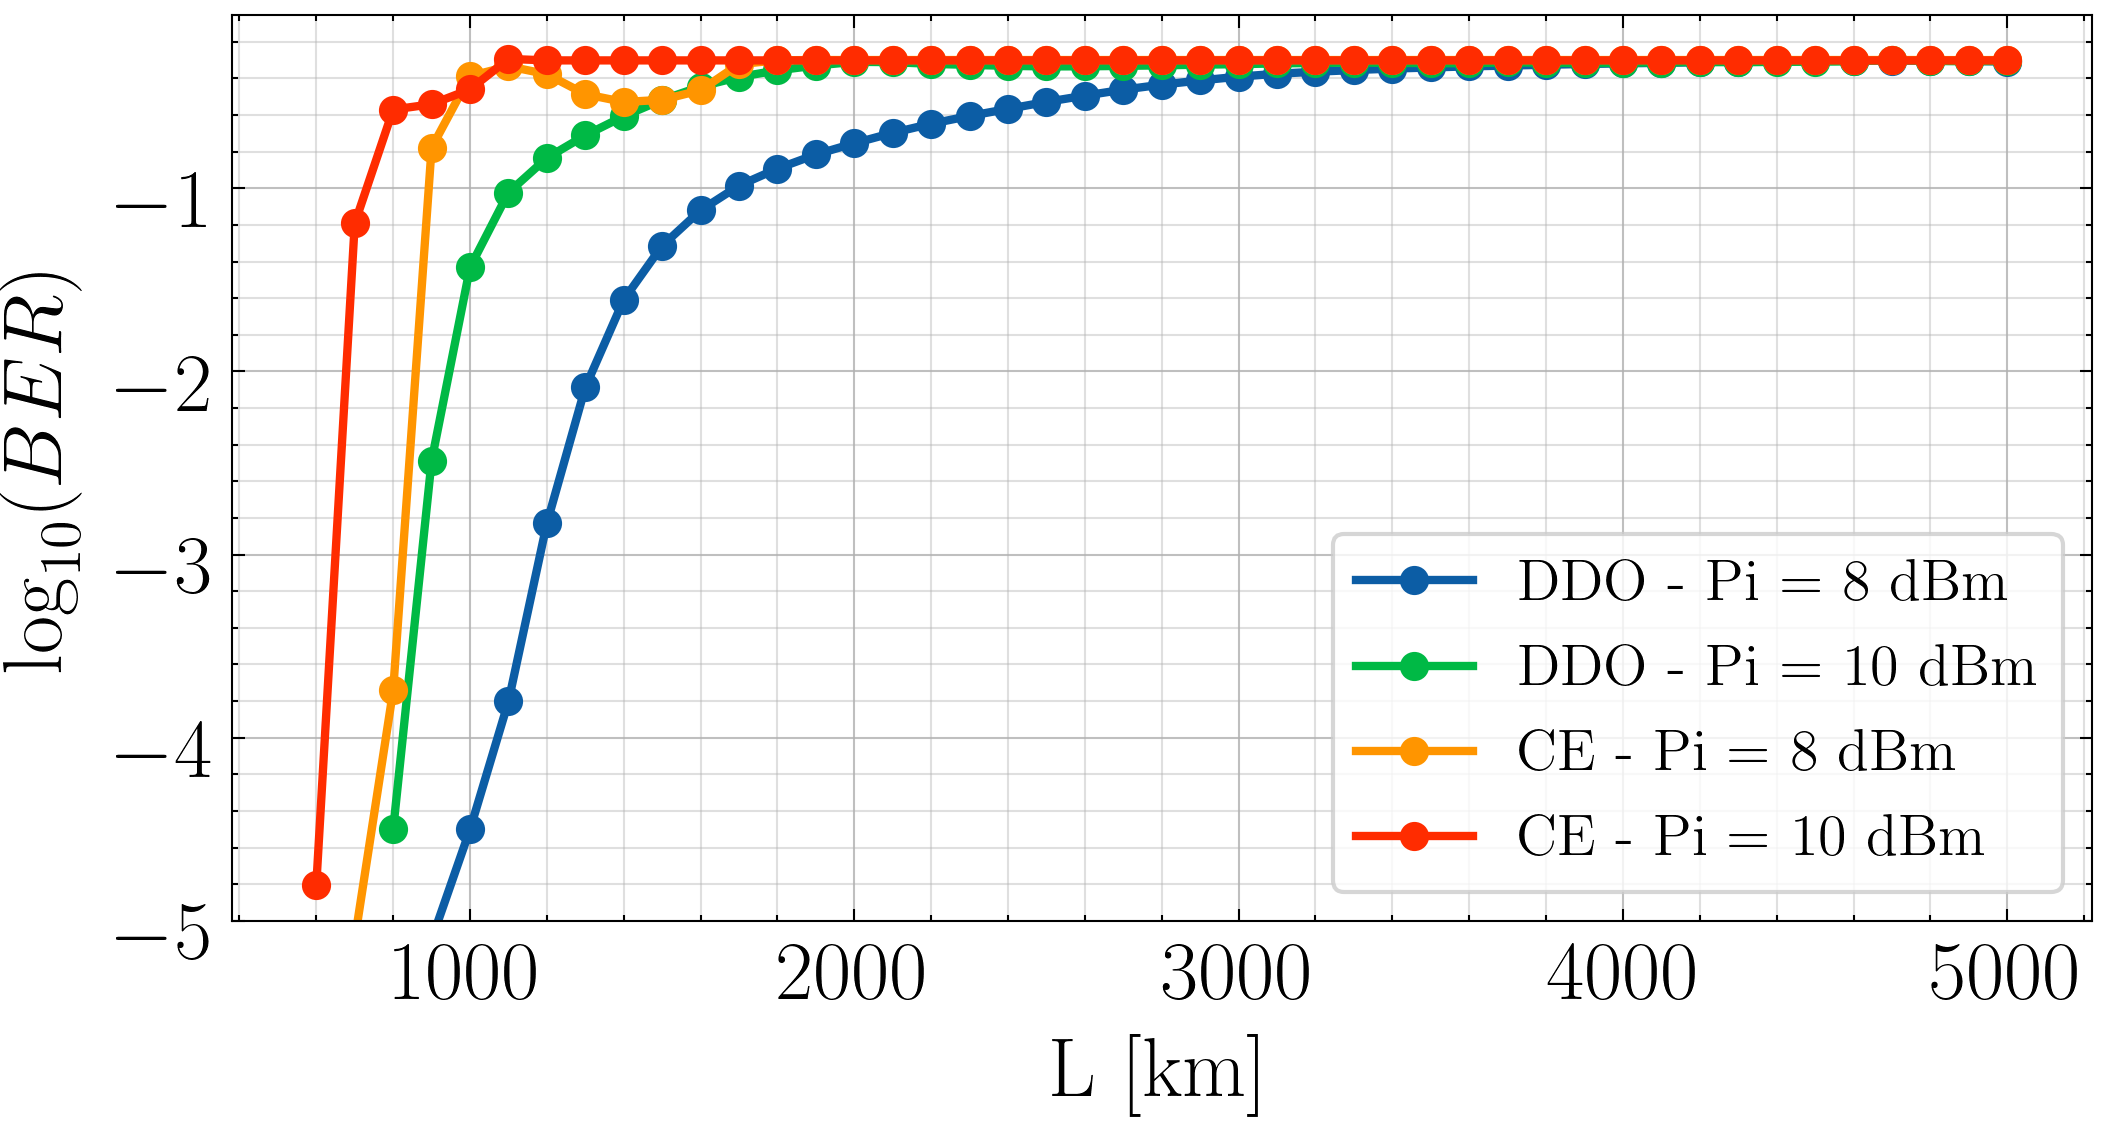

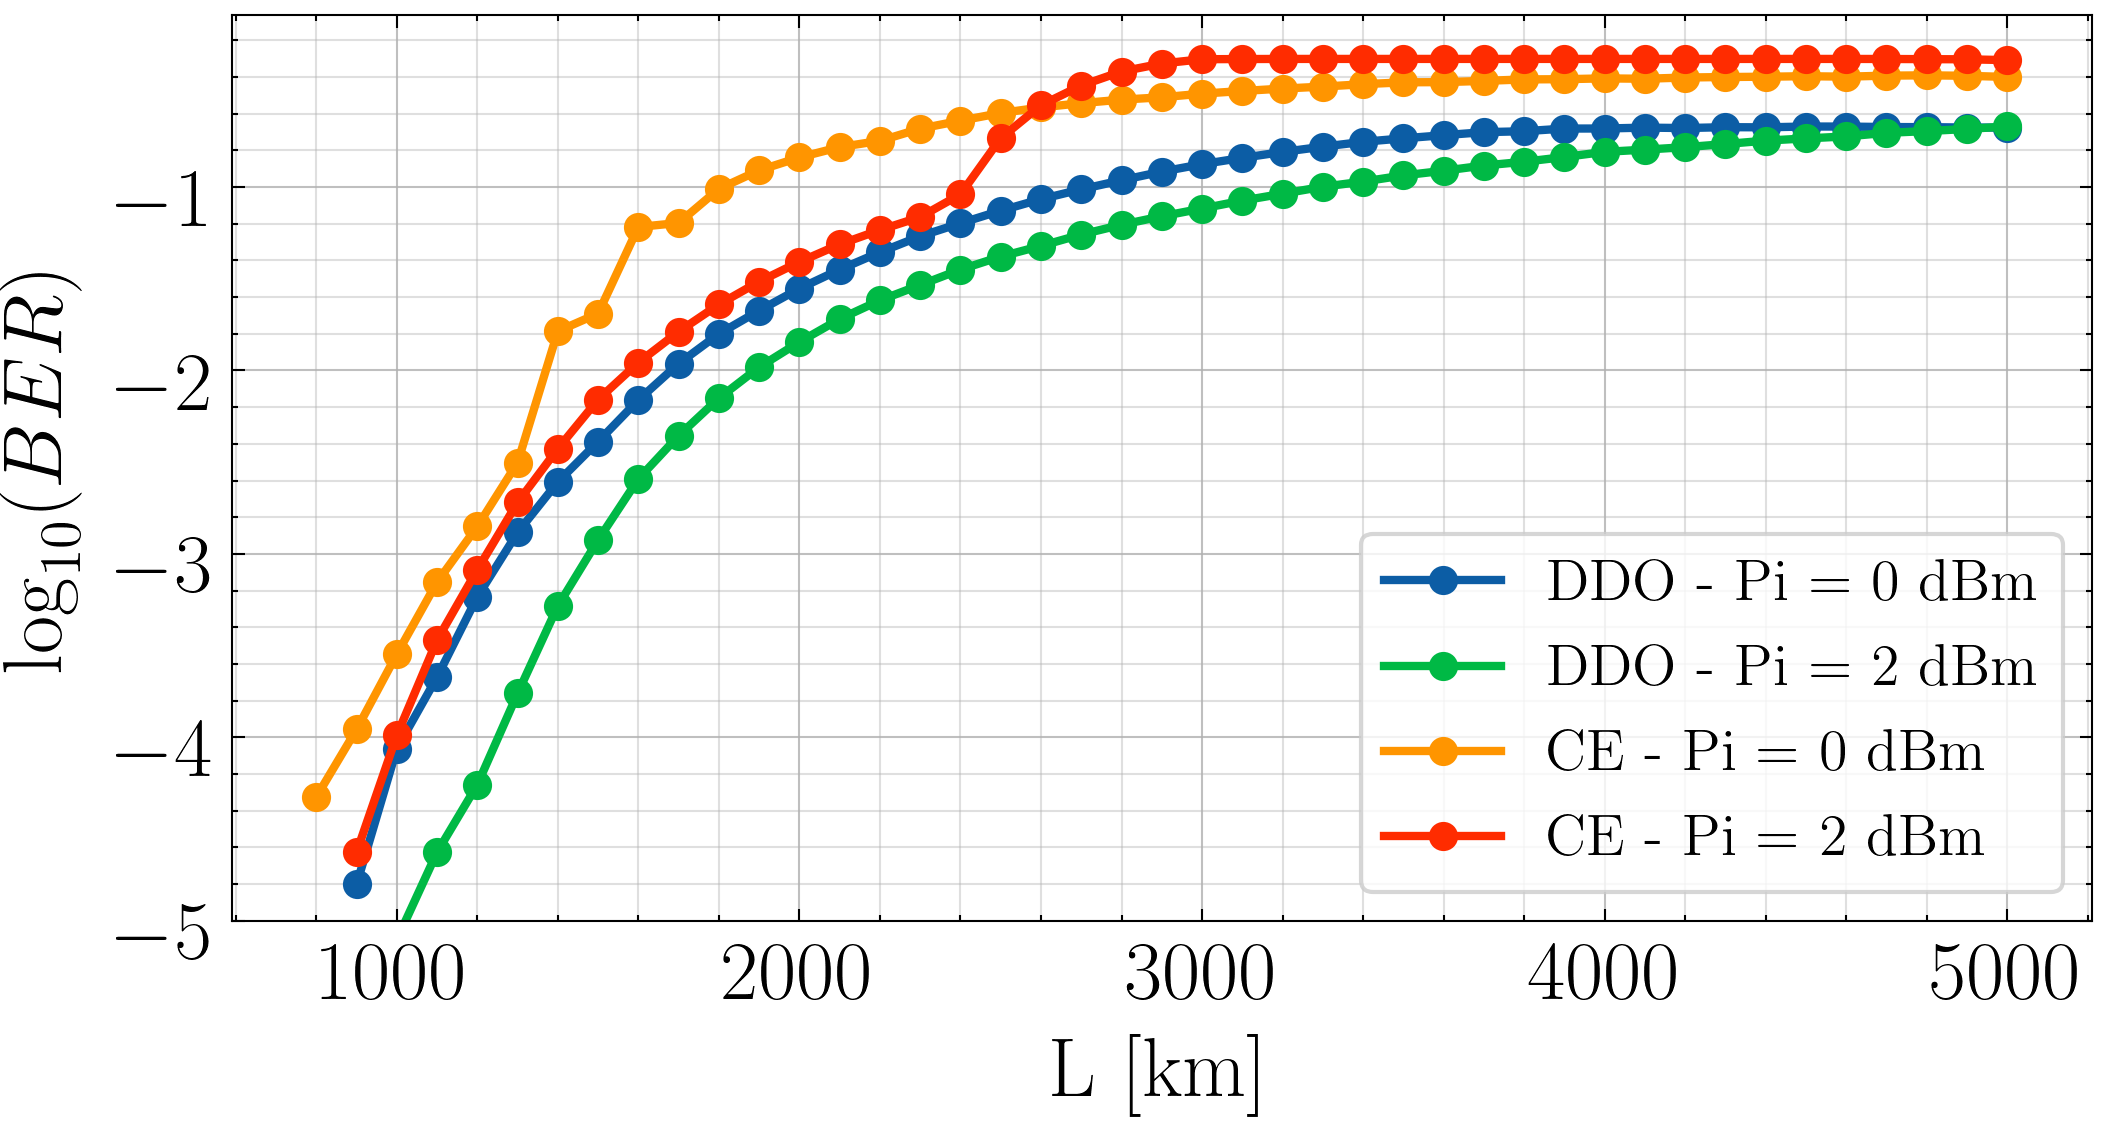

In [205]:
plt.figure(figsize = (8, 4))

plt.plot(L, np.log10(BER_DD_L[2,:]), '-o', ms = 6, lw = 2, label = "DDO - Pi = 8 dBm")
plt.plot(L, np.log10(BER_DD_L[3,:]), '-o', ms = 6, lw = 2, label = "DDO - Pi = 10 dBm")
plt.plot(L, np.log10(BER_CEDD_L[2,:]), '-o', ms = 6, lw = 2, label = "CE - Pi = 8 dBm")
plt.plot(L, np.log10(BER_CEDD_L[3,:]), '-o', ms = 6, lw = 2, label = "CE - Pi = 10 dBm")


plt.xlabel(r"L [km]")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
#plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)


plt.figure(figsize = (8, 4))

plt.plot(L, np.log10(BER_DD_L[0,:]), '-o', ms = 6, lw = 2, label = "DDO - Pi = 0 dBm")
plt.plot(L, np.log10(BER_DD_L[1,:]), '-o', ms = 6, lw = 2, label = "DDO - Pi = 2 dBm")
plt.plot(L, np.log10(BER_CEDD_L[0,:]), '-o', ms = 6, lw = 2, label = "CE - Pi = 0 dBm")
plt.plot(L, np.log10(BER_CEDD_L[1,:]), '-o', ms = 6, lw = 2, label = "CE - Pi = 2 dBm")

plt.xlabel(r"L [km]")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
#plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered 

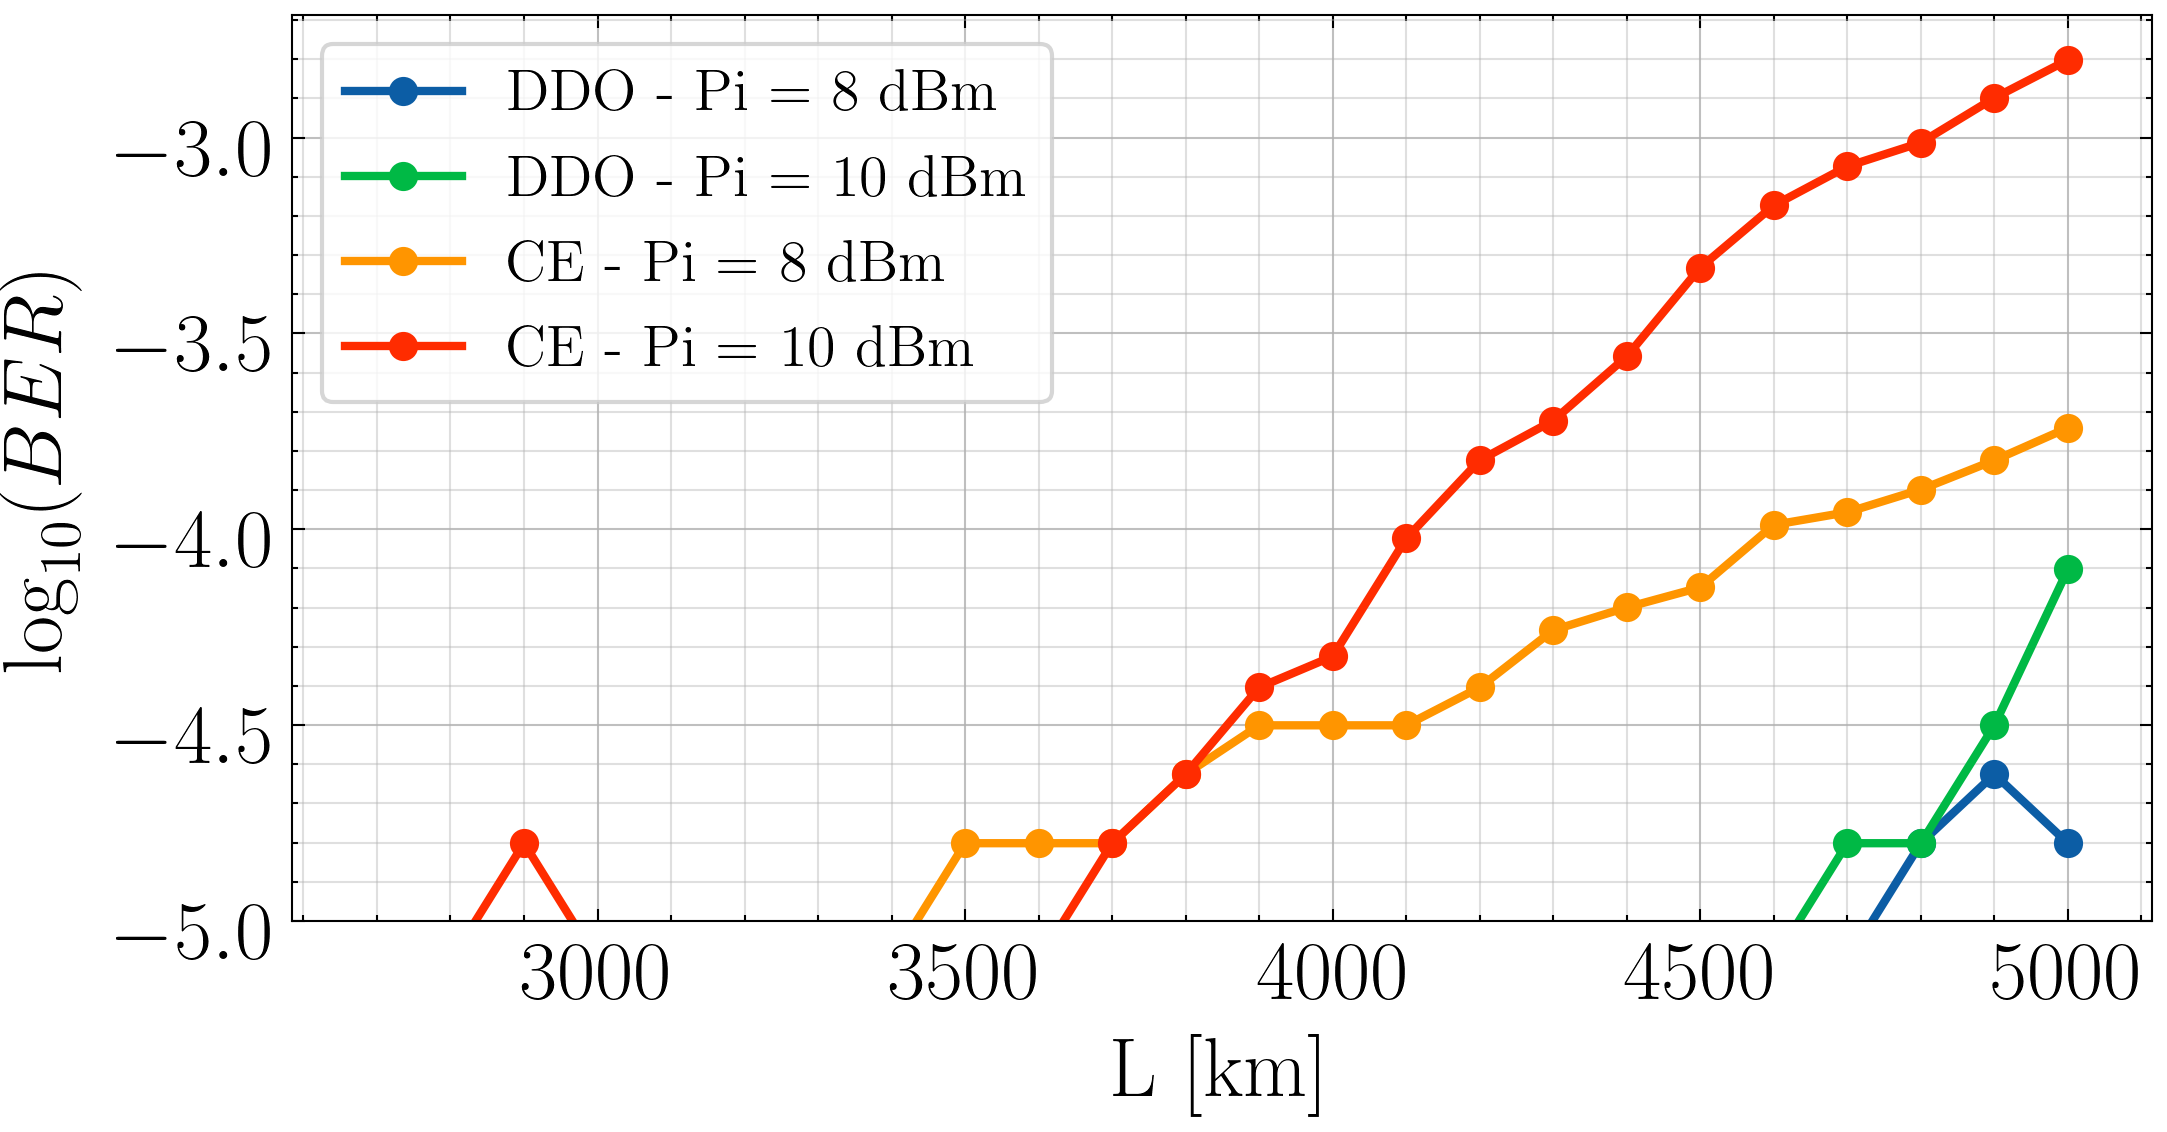

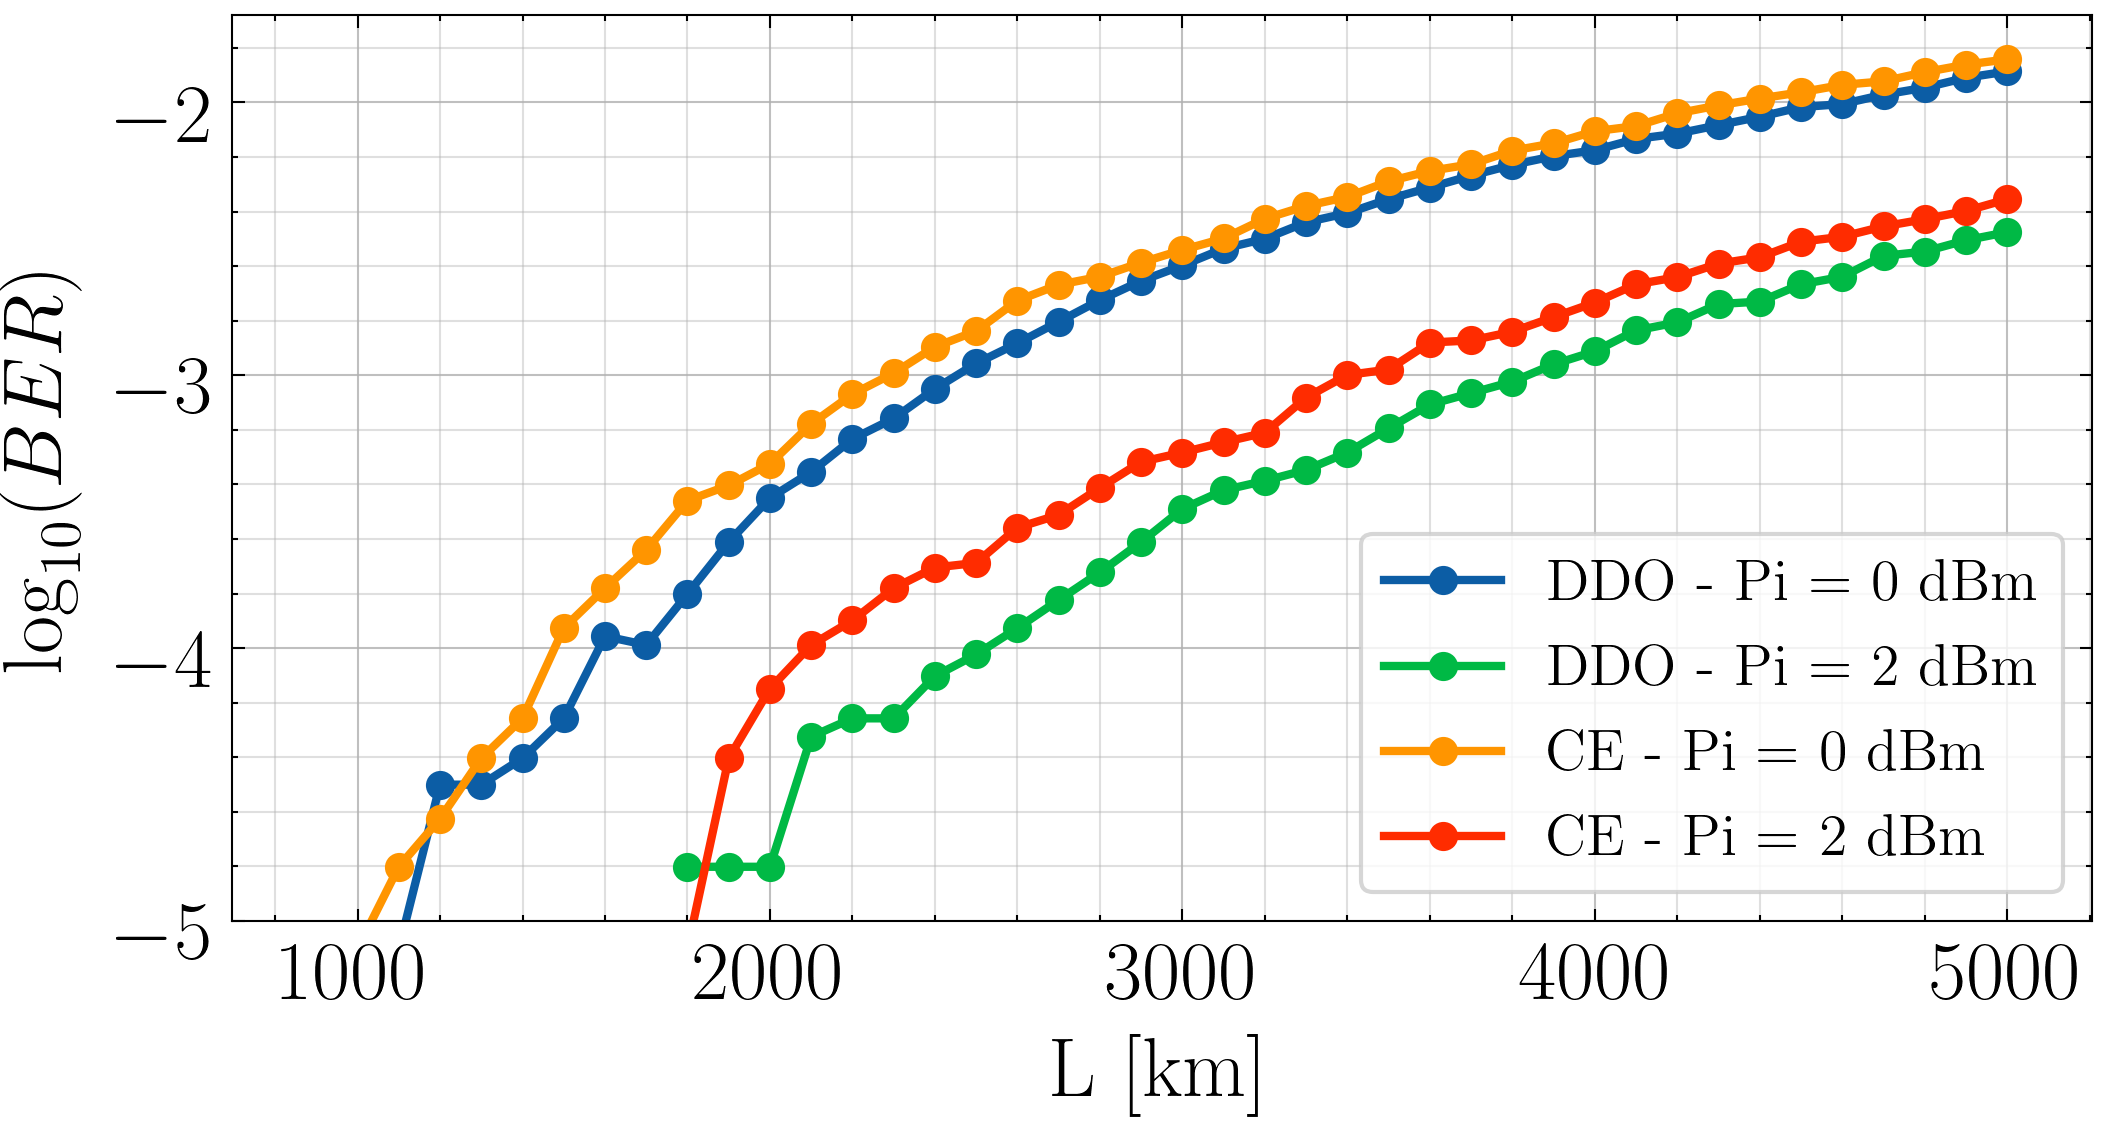

In [213]:
plt.figure(figsize = (8, 4))

plt.plot(L, np.log10(BER_DD_Leq[2,:]), '-o', ms = 6, lw = 2, label = "DDO - Pi = 8 dBm")
plt.plot(L, np.log10(BER_DD_Leq[3,:]), '-o', ms = 6, lw = 2, label = "DDO - Pi = 10 dBm")
plt.plot(L, np.log10(BER_CEDD_Leq[2,:]), '-o', ms = 6, lw = 2, label = "CE - Pi = 8 dBm")
plt.plot(L, np.log10(BER_CEDD_Leq[3,:]), '-o', ms = 6, lw = 2, label = "CE - Pi = 10 dBm")


plt.xlabel(r"L [km]")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
#plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)


plt.figure(figsize = (8, 4))

plt.plot(L, np.log10(BER_DD_Leq[0,:]), '-o', ms = 6, lw = 2, label = "DDO - Pi = 0 dBm")
plt.plot(L, np.log10(BER_DD_Leq[1,:]), '-o', ms = 6, lw = 2, label = "DDO - Pi = 2 dBm")
plt.plot(L, np.log10(BER_CEDD_Leq[0,:]), '-o', ms = 6, lw = 2, label = "CE - Pi = 0 dBm")
plt.plot(L, np.log10(BER_CEDD_Leq[1,:]), '-o', ms = 6, lw = 2, label = "CE - Pi = 2 dBm")

plt.xlabel(r"L [km]")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
#plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

In [178]:
# Sinal DDO-OFDM
paramTx.g = 0.50
paramTx.Scheme = "DDO-OFDM"

sigTxoDD, sigTxDD, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)
sigTxoDD = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxoDD/np.sqrt(signal_power(sigTxoDD))

# Sinal CE-DDO-OFDM
paramTx.A = 1.15
paramTx.H = 0.45/(2*pi)
paramTx.Scheme = "CE-DDO-OFDM"

sigTxoCE, sigTxCE, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
sigTxoCE = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxoCE/np.sqrt(signal_power(sigTxoCE))

(-200, -83.98572976429803)

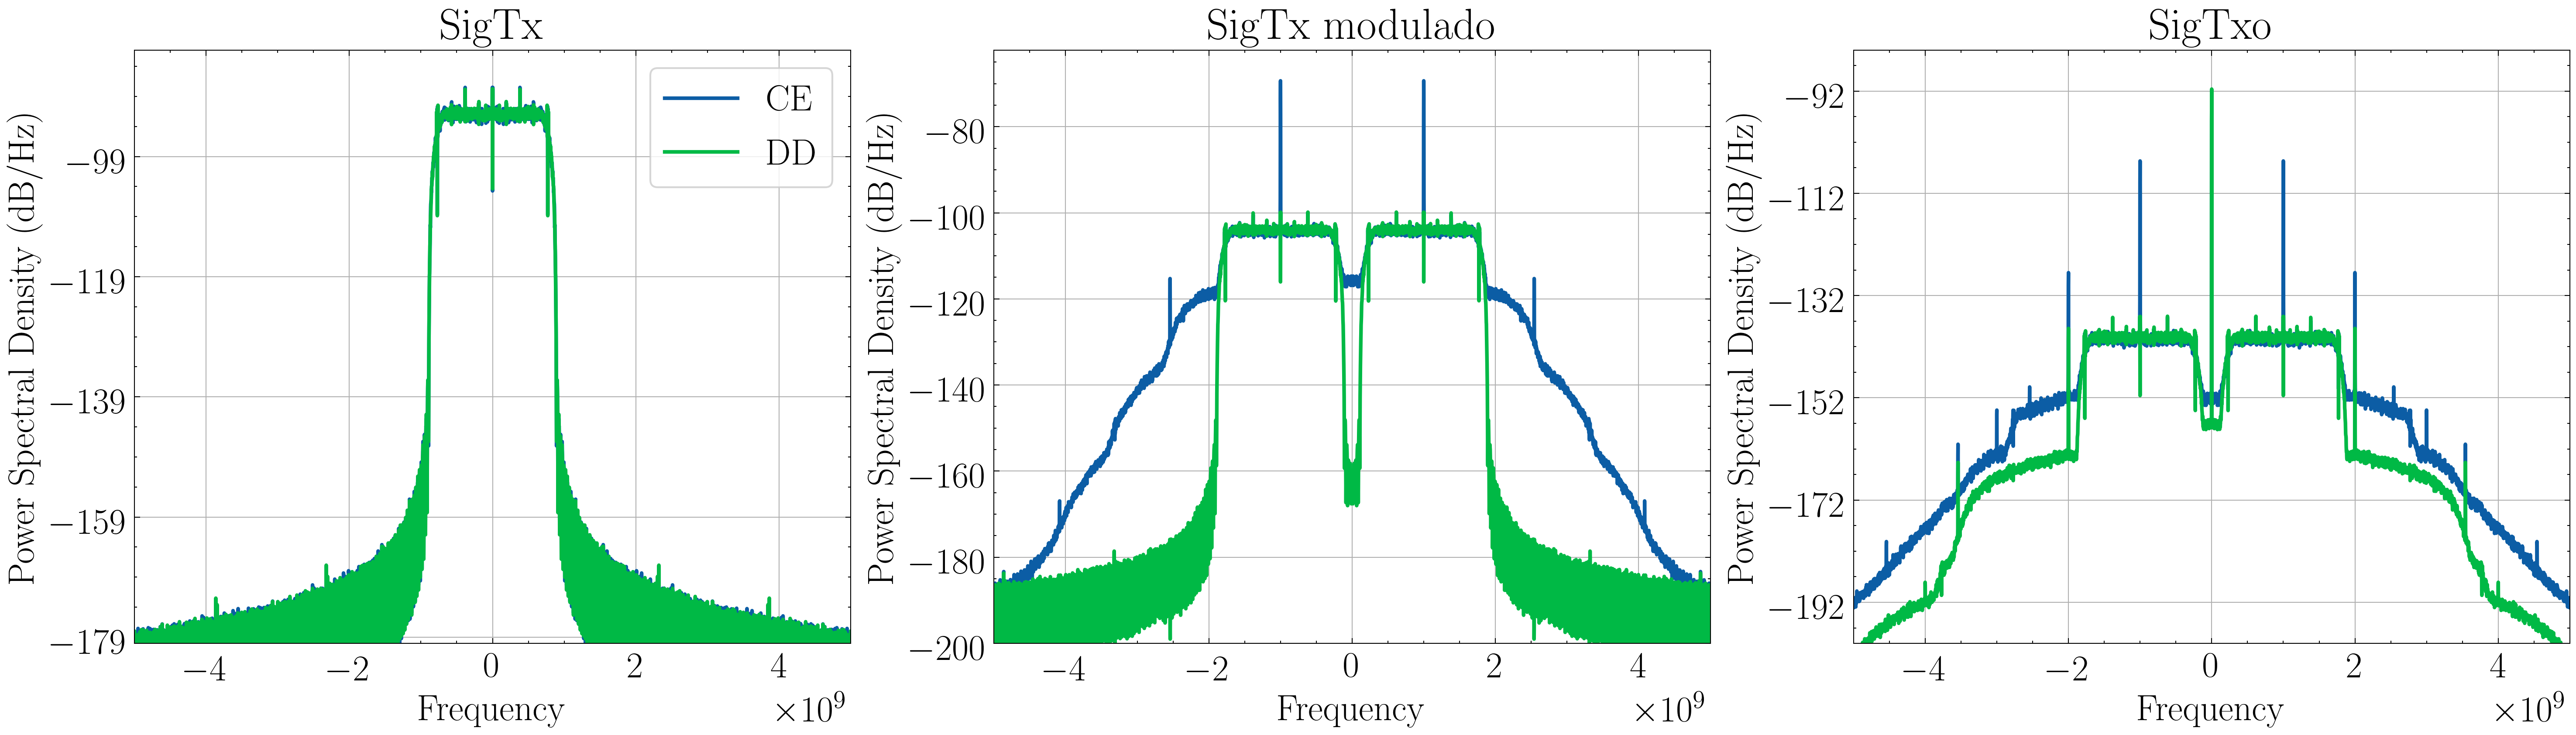

In [179]:
fig, ax = plt.subplots(1, 3, figsize = (24, 6))

ax[0].psd(sigTxCE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[0].psd(sigTxDD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[0].set_title('SigTx')
ax[0].legend(frameon = True)
ax[0].set_xlim(-5e9, 5e9)
ax[0].set_ylim(-180)

ax[1].psd(sigTx_CE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[1].psd(sigTx_DD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[1].set_title('SigTx modulado')
ax[1].set_xlim(-5e9, 5e9)
ax[1].set_ylim(-200)

ax[2].psd(sigTxoCE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[2].psd(sigTxoDD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[2].set_title('SigTxo')
ax[2].set_xlim(-5e9, 5e9)
ax[2].set_ylim(-200)

## 2.2 - Com compensação de dispersão

In [ ]:
paramTx.H = ?
paramRx.H = paramTx.H
paramTx.Vb = ?*paramTx.Vπ

Pi = np.arange(-5, 12.5)

BER_CEDD_Pi = np.zeros(len(Pi))
SNR_CEDD_Pi = np.zeros(len(Pi))

paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(Pi))):
    paramTx.Pi_dBm = Pi[i]
        
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
    sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
    ipd = photodiode(sigRxo, paramPD)
        
    symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
    BER_CEDD_Pi[i], _, SNR_CEDD_Pi[i] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')  

In [ ]:
paramTx.Vb = ?*paramTx.Vπ

BER_DD_Pi = np.zeros(len(Pi))
SNR_DD_Pi = np.zeros(len(Pi))

paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(Pi))):
    paramTx.Pi_dBm = Pi[i]
        
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
    sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
    ipd = photodiode(sigRxo, paramPD)
        
    symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
    BER_DD_Pi[i], _, SNR_DD_Pi[i] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam') 

In [ ]:
# BER vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, np.log10(BER_CEDD_Pi), '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Pi, np.log10(BER_DD_Pi), '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# SNR vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, SNR_CEDD_Pi, '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Pi, SNR_DD_Pi, '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"SNR [dB]")
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), max(Pi))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

In [23]:
# CE-DDO-OFDM
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = "CE-DDO-OFDM"

paramTx.A = 1.4
paramTx.H = 0.55/(2*pi)
paramRx.H = paramTx.H

Pi_dBm  = np.array([2])
Ltotal  = np.arange(100, 1000, 100)

BER_CE_16QAM  = np.zeros((len(Pi_dBm), len(Ltotal)))

for i in range(len(Pi_dBm)):
    paramTx.Pi_dBm = Pi_dBm[i]
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
    sigRxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    
    for j in tqdm(range(len(Ltotal))):
        sigRxo,_  = ssfm(sigRxo, paramTx.Fa, paramCh)
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_CE_16QAM[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/9 [00:00<?, ?it/s]

In [24]:
np.log10(BER_CE_16QAM)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


array([[       -inf,        -inf,        -inf,        -inf,        -inf,
        -5.11581014, -4.51375015, -3.68444638, -3.24657842]])

In [25]:
# DDO-OFDM
paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = "DDO-OFDM"

Pi_dBm  = np.array([2])
Ltotal  = np.arange(100, 1000, 100)
BER_DD_16QAM  = np.zeros((len(Pi_dBm), len(Ltotal)))

for i in range(len(Pi_dBm)):
    paramTx.Pi_dBm = Pi_dBm[i]
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)
    sigRxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    
    for j in tqdm(range(len(Ltotal))):
        sigRxo,_  = ssfm(sigRxo, paramTx.Fa, paramCh)
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_DD_16QAM[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/9 [00:00<?, ?it/s]

In [26]:
np.log10(BER_DD_16QAM)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


array([[       -inf,        -inf,        -inf,        -inf,        -inf,
               -inf, -5.11581014, -4.63868889, -3.93971888]])

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


IndexError: index 2 is out of bounds for axis 0 with size 1

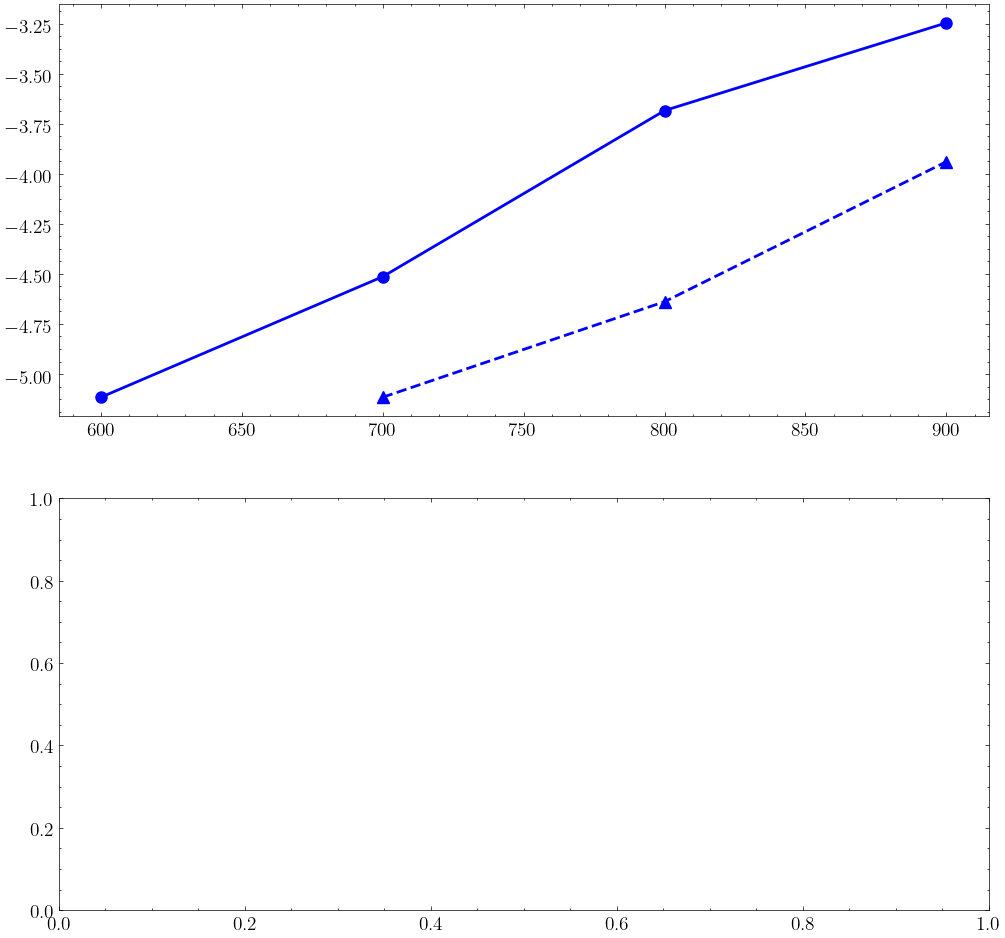

In [27]:
fig, axs = plt.subplots(2, 1, figsize = (12, 12))
color = ['blue', 'orange', 'green', 'purple']

for i in range(2):
    axs[0].plot(Ltotal, np.log10(BER_CE_16QAM[i,:]), '-o', color = color[i], ms = 8, lw = 2, label = f"CE - {Pi_dBm[i]} dBm")
    axs[0].plot(Ltotal, np.log10(BER_DD_16QAM[i,:]), '--^', color = color[i], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i]} dBm")
    
    axs[1].plot(Ltotal, np.log10(BER_CE_16QAM[i+2,:]), '-o', color = color[i+2], ms = 8, lw = 2, label = f"CE - {Pi_dBm[i+2]} dBm")
    axs[1].plot(Ltotal, np.log10(BER_DD_16QAM[i+2,:]), '--^', color = color[i+2], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i+2]} dBm")
    
axs[0].set_xlabel(r"L [km]")
axs[0].set_ylabel(r"$\log_{10}(BER)$")
axs[0].set_ylim(-4.5)
axs[0].grid(which='minor', alpha=0.2)
axs[0].grid(which='major', alpha=0.5)

handles,labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

axs[0].legend(handles, labels, frameon = True)

axs[1].set_xlabel(r"L [km]")
axs[1].set_ylabel(r"$\log_{10}(BER)$")
axs[1].set_ylim(-4.5)
axs[1].grid(which='minor', alpha=0.2)
axs[1].grid(which='major', alpha=0.5)

handles,labels = axs[1].get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

axs[1].legend(handles, labels, frameon = True)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


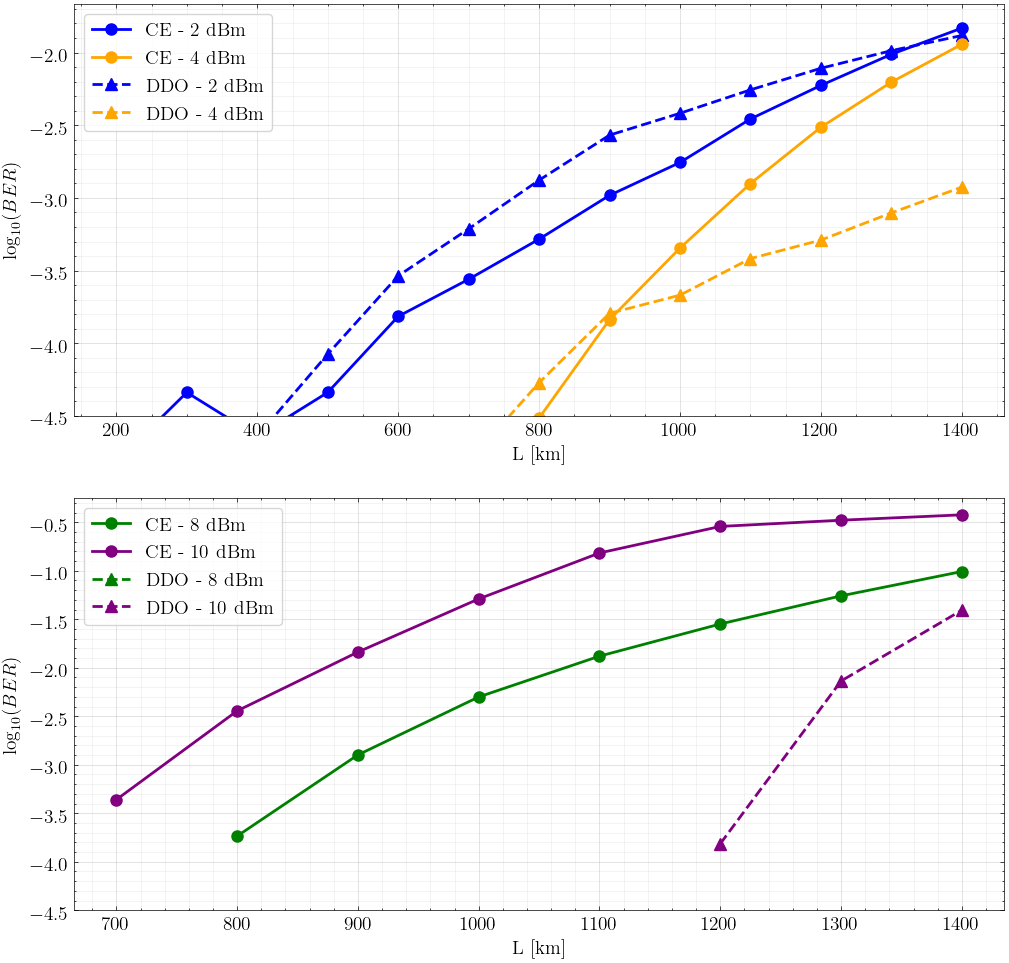

In [76]:
fig, axs = plt.subplots(2, 1, figsize = (12, 12))
color = ['blue', 'orange', 'green', 'purple']

for i in range(2):
    axs[0].plot(Ltotal, np.log10(BER_CE_16QAM[i,:]), '-o', color = color[i], ms = 8, lw = 2, label = f"CE - {Pi_dBm[i]} dBm")
    axs[0].plot(Ltotal, np.log10(BER_DD_16QAM[i,:]), '--^', color = color[i], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i]} dBm")
    
    axs[1].plot(Ltotal, np.log10(BER_CE_16QAM[i+2,:]), '-o', color = color[i+2], ms = 8, lw = 2, label = f"CE - {Pi_dBm[i+2]} dBm")
    axs[1].plot(Ltotal, np.log10(BER_DD_16QAM[i+2,:]), '--^', color = color[i+2], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i+2]} dBm")
    
axs[0].set_xlabel(r"L [km]")
axs[0].set_ylabel(r"$\log_{10}(BER)$")
axs[0].set_ylim(-4.5)
axs[0].grid(which='minor', alpha=0.2)
axs[0].grid(which='major', alpha=0.5)

handles,labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

axs[0].legend(handles, labels, frameon = True)

axs[1].set_xlabel(r"L [km]")
axs[1].set_ylabel(r"$\log_{10}(BER)$")
axs[1].set_ylim(-4.5)
axs[1].grid(which='minor', alpha=0.2)
axs[1].grid(which='major', alpha=0.5)

handles,labels = axs[1].get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

axs[1].legend(handles, labels, frameon = True)

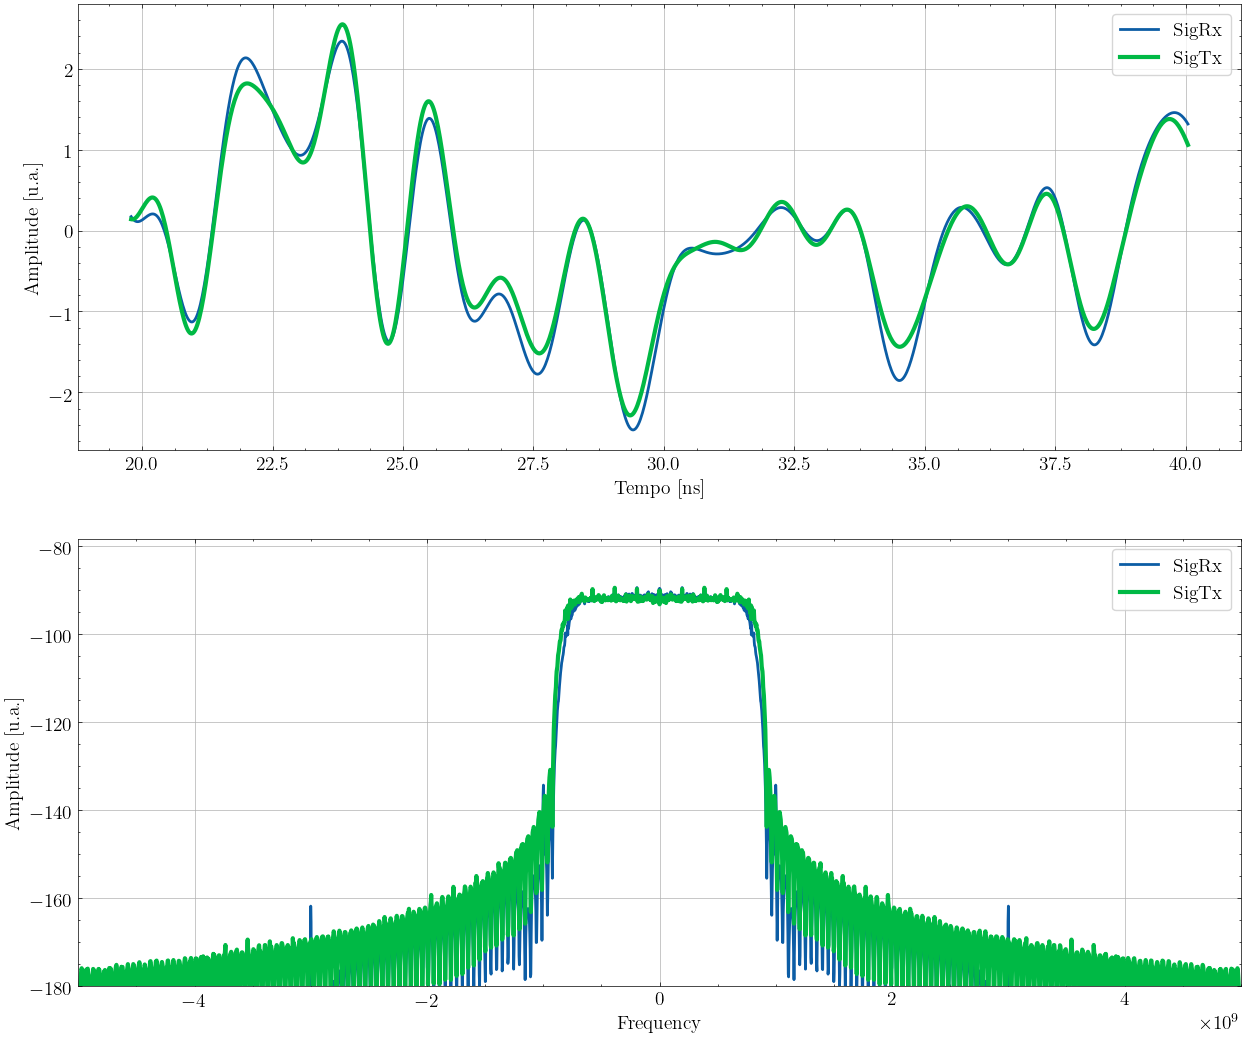

In [50]:
fig, ax = plt.subplots(2, 1, figsize = (15, 13))

idX = np.arange(1000, 2024)

ax[0].plot(t[idX]*1e9, sigRx[idX], lw = 2, label = "SigRx")
ax[0].plot(t[idX]*1e9, sigTx[idX].real, lw = 3, label = "SigTx")
ax[0].set_xlabel('Tempo [ns]')
ax[0].set_ylabel('Amplitude [u.a.]')
ax[0].legend(frameon = True)
ax[0].grid()

ax[1].psd(sigRx, Fs=paramTx.Fa, NFFT = 16*1024, lw = 2, sides='twosided', label = "SigRx")
ax[1].psd(sigTx, Fs=paramTx.Fa, NFFT = 16*1024, lw = 3, sides='twosided', label = "SigTx")
ax[1].set_ylabel('Amplitude [u.a.]')
ax[1].set_xlim(-5e9, 5e9)
ax[1].set_ylim(-180)
ax[1].legend(frameon = True)